# Jira Case Study 

Author: Ari Yeganeh

In this notebook, we'll be exploring the dataset provided here: https://drive.google.com/file/d/1lwTnTOjjtbvde9onV52UAr0FRT6Jtkdj/view?usp=sharing


This data is a very small subset of our customers (16 instances) for Jira family of products. It covers ~1 month and represents ~500 end users.
All strings and some numeric values are hashed for privacy reasons. However, the same hashing method is used for each string, so it is possible to link for example 'issueKey' across different events.

We will be aiming to answer the following questions:
1. Describe the data set in broad strokes.  Note down any data anomalies, outliers or anything you think is unusual in the data set.
2.  Compare users `778251ffec35de6bbbb089198b9ac516` and `7e7a085a9f6f55253b2aa15dbcb702a8` from the instance `c93da7e17688ef90fc43963b5a6c6259`; would you conclude their average number of events per day to be different? Justify your answer.
3.  Our users tend to use multiple features together when they use our products. Cluster events that tend to appear together into groups, and explain how and why you have clustered events in such a way.
4.  Is there anything else you find interesting about the usage pattern you'd like to tell us?


Let's begin with reading in and preparing our environment and dataset.



In [1]:
import pandas as pd 
import numpy as np
from pandasql import sqldf
import seaborn  as sns 
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
%matplotlib inline

from matplotlib import rcParams
rcParams.update({'font.size': 18})
rcParams['font.style'] = 'normal' 
rcParams['figure.dpi'] = 300 


Data dictionary provided:
- **time_string** : Date and time in readable format
- **unix_time** : Timestamp (in milliseconds)
- **instance** : The name of the customer
- **product** : Always equal to 'jira'
- **username** : A user ID
- **event**: action that user makes. Typically one event per user-click, but that's not always the case since sometimes one action may trigger more than one event.
- **attributes** : Extra information about the event in JSON-like format

In [2]:
# read in the data after downloading from above url
df = pd.read_csv("jira_clean.tsv", sep='\t', header=None)  # specify NULL handlers

# Let's rename our column headers as above
df.columns = ['time_string', 'unix_time', 'instance', 'product', 'username', 'event', 'attributes']

df_backup = df #let's create a backup of original data

# read in JSON, split columns potentially sparse, map out to events
# check for dupes

&nbsp; 

## 1. Describe the data set in broad strokes. Note down any data anomalies, outliers or anything you think is unusual in the data set.



In [3]:
df.head()

time_string      unix_time                          instance  \
0  2014-12-01 16:00:02,153  1417410002153  3998740a9e4924af7feedeb2e04190f6   
1  2014-12-01 16:00:07,691  1417410007691  3998740a9e4924af7feedeb2e04190f6   
2  2014-12-01 16:00:07,691  1417410007691  3998740a9e4924af7feedeb2e04190f6   
3  2014-12-01 16:00:07,691  1417410007691  3998740a9e4924af7feedeb2e04190f6   
4  2014-12-01 16:00:10,523  1417410010523  c93da7e17688ef90fc43963b5a6c6259   

  product                          username  \
0    jira  d50d63ec8ecdf32d1dd9ae4a0cecd2f8   
1    jira  d50d63ec8ecdf32d1dd9ae4a0cecd2f8   
2    jira  d50d63ec8ecdf32d1dd9ae4a0cecd2f8   
3    jira  d50d63ec8ecdf32d1dd9ae4a0cecd2f8   
4    jira  2cc91ff23ca6213e8a7d2513a31d8fa8   

                               event  \
0                        quickbrowse   
1  kickass.criteriaAutoUpdateEnabled   
2                  kickass.viewIssue   
3                  browserWindowSize   
4                    lexorankbalance   

                                          attributes  
0   {'issueKey': 'eaf34eb91618cf3e1bf487a822a2cce6'}  
1  {'context_pageTime': '6ce628243b670aff9f549029...  
2  {'context_pageSession': 'a09b1242b4712e1cb23bf...  
3  {'width': '00409424d52c3a1a30e98cd1cd91638a', ...  
4  {'fieldId': '4537ecbd3f85c18825157673510a445d'...

The dataset at high level looks quite clean and well structured.

In [4]:
df.sample(frac = 0.00001)

time_string      unix_time  \
223213  2014-12-11 03:47:51,147  1418230071147   
580807  2014-12-31 10:01:13,819  1419980473819   
318192  2014-12-16 15:13:20,332  1418703200332   
148188  2014-12-08 14:17:05,020  1418008625020   
380349  2014-12-18 14:39:20,736  1418873960736   
445837  2014-12-22 14:35:19,280  1419219319280   

                                instance product  \
223213  8451474057772fcb26feb117bf3923d5    jira   
580807  c93da7e17688ef90fc43963b5a6c6259    jira   
318192  c93da7e17688ef90fc43963b5a6c6259    jira   
148188  c93da7e17688ef90fc43963b5a6c6259    jira   
380349  c93da7e17688ef90fc43963b5a6c6259    jira   
445837  c93da7e17688ef90fc43963b5a6c6259    jira   

                                username                              event  \
223213  e1a785fef4d9ef4d28987b9761425022                  kickass.viewIssue   
580807  3754cd4045e668324b20c70bd9f3eaff  experiments.performance.inclusion   
318192  618a24869412a5d8932d3c220043b467          kickass.issueLoadDuration   
148188  7e7a085a9f6f55253b2aa15dbcb702a8          kickass.issueLoadDuration   
380349  107ad5d193509959277af65d303cd837                      dashboardview   
445837  faa1cfe141de0404e9b58299244500ce                  kickass.viewIssue   

                                               attributes  
223213  {'duration': 'c61f0e3b07917b605b1690bdc08b48ec...  
580807  {'inclusionMillis': 'ebdbbb499fb3ba0c693018cab...  
318192  {'duration': 'b9e4ed4d88e5b02f4e66f69dd6289d66...  
148188  {'duration': '9885754de4253f16ad0ac6b4fb417930...  
380349         {'id': '46d368b37e83ff5897fad38aa9d7d7fc'}  
445837  {'context_pageSession': '06f2a271e71d3829948e9...

Looking at a randomly selected sample confirms the structure is similar across the data.

In [5]:
# check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 592458 entries, 0 to 592457
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   time_string  592458 non-null  object
 1   unix_time    592458 non-null  int64 
 2   instance     592458 non-null  object
 3   product      592458 non-null  object
 4   username     592458 non-null  object
 5   event        592458 non-null  object
 6   attributes   592458 non-null  object
dtypes: int64(1), object(6)
memory usage: 31.6+ MB



High level our data looks to be complete without any missing values. 

We note here that the attributes column contains JSON structured data which we can dig into a bit later if time permits. Looking at the samples it does look like the attributes are related to events and hence sparse in nature.

Looking at column types, we need to convert time_string into appropriate date field.

In [6]:
df['time_string'] = pd.to_datetime(df['time_string'])

# and let's create a new column capturing the date
df['date'] = pd.to_datetime(df['time_string'].dt.date)



Let's look at some key columns and their distributions:


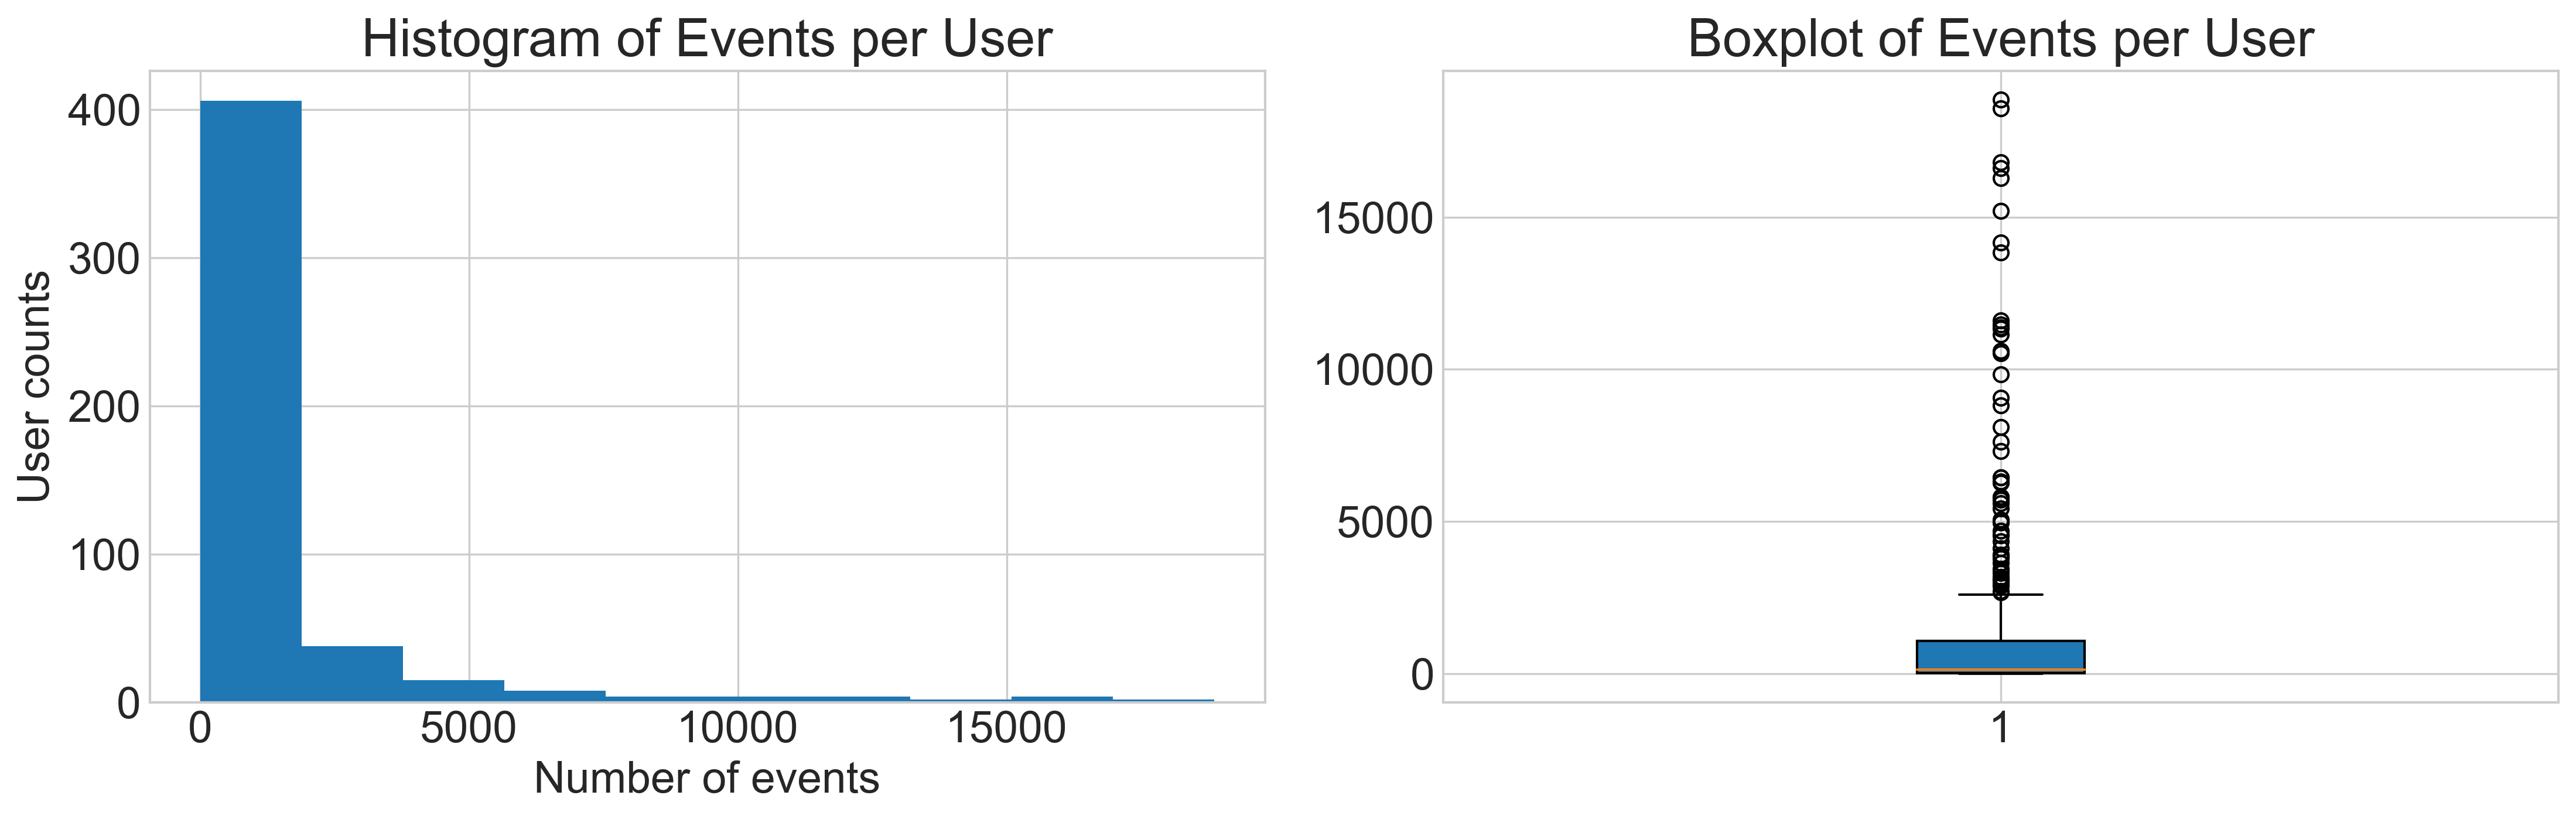

In [7]:
user_count = df['username'].value_counts()

plt.subplots(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.hist(user_count)
plt.title('Histogram of Events per User')
plt.xlabel('Number of events')
plt.ylabel('User counts')

plt.subplot(1, 2, 2)
plt.title('Boxplot of Events per User')
plt.boxplot(user_count, patch_artist=True)
plt.tight_layout()
plt.show()


&nbsp; 

Here we can see quite a wide distribution for events per user suggesting different user profiles of Jira. e.g. Power users vs. Typical users vs. Lite users.

We may want to investigate the types of events users are engaged in to verify these are valid actions.

At this point it's difficult to rule out any user activity without deep diving into types of events and event attributes.


We can see a similar long tail distribution for the types of events users are engaged in. However, we need to dig deeper into the types of events as not all are directly related/relevant to user actions. 

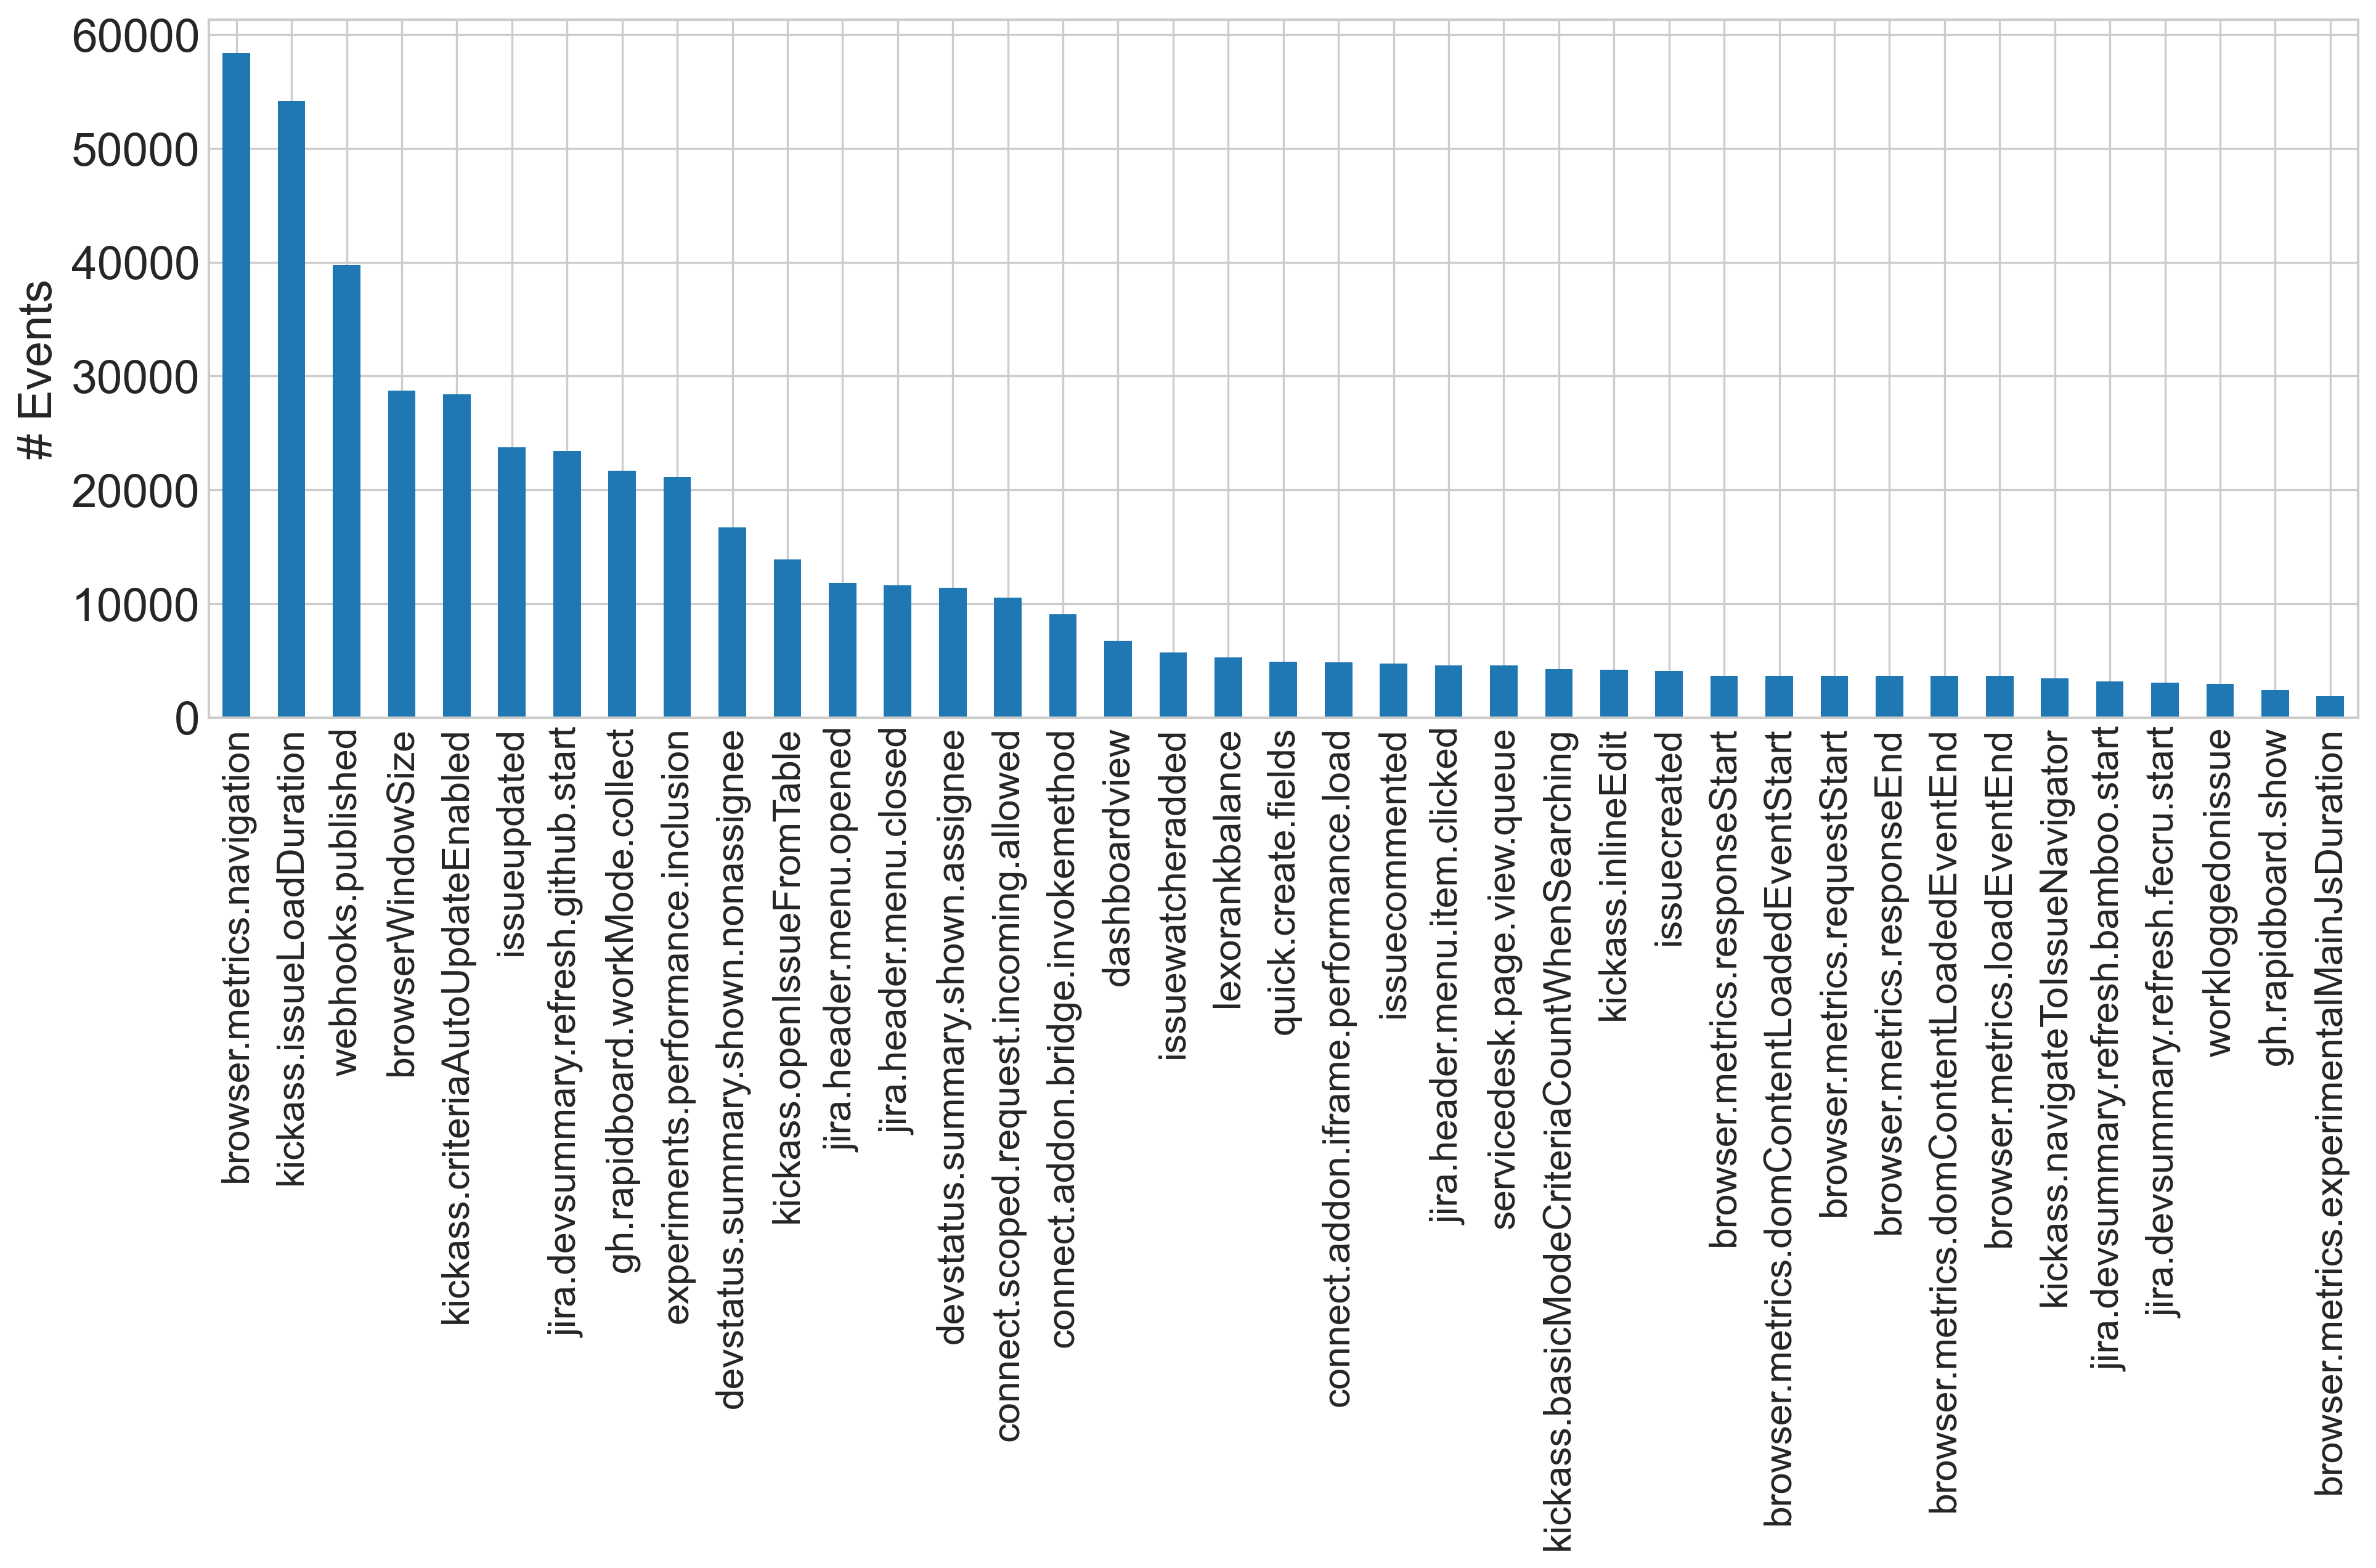

In [8]:
plt.subplots(figsize=(15, 5))
df['event'].value_counts()[1:40].plot(kind="bar")
plt.ylabel('# Events')
plt.rc('xtick',labelsize=8)
plt.xticks(
    fontweight='light',
    fontsize='small'  
)
plt.show()

&nbsp; 

We can see the number of events over time varies significantly and there seems to be a drop off on weekends.
Let's explore more below...


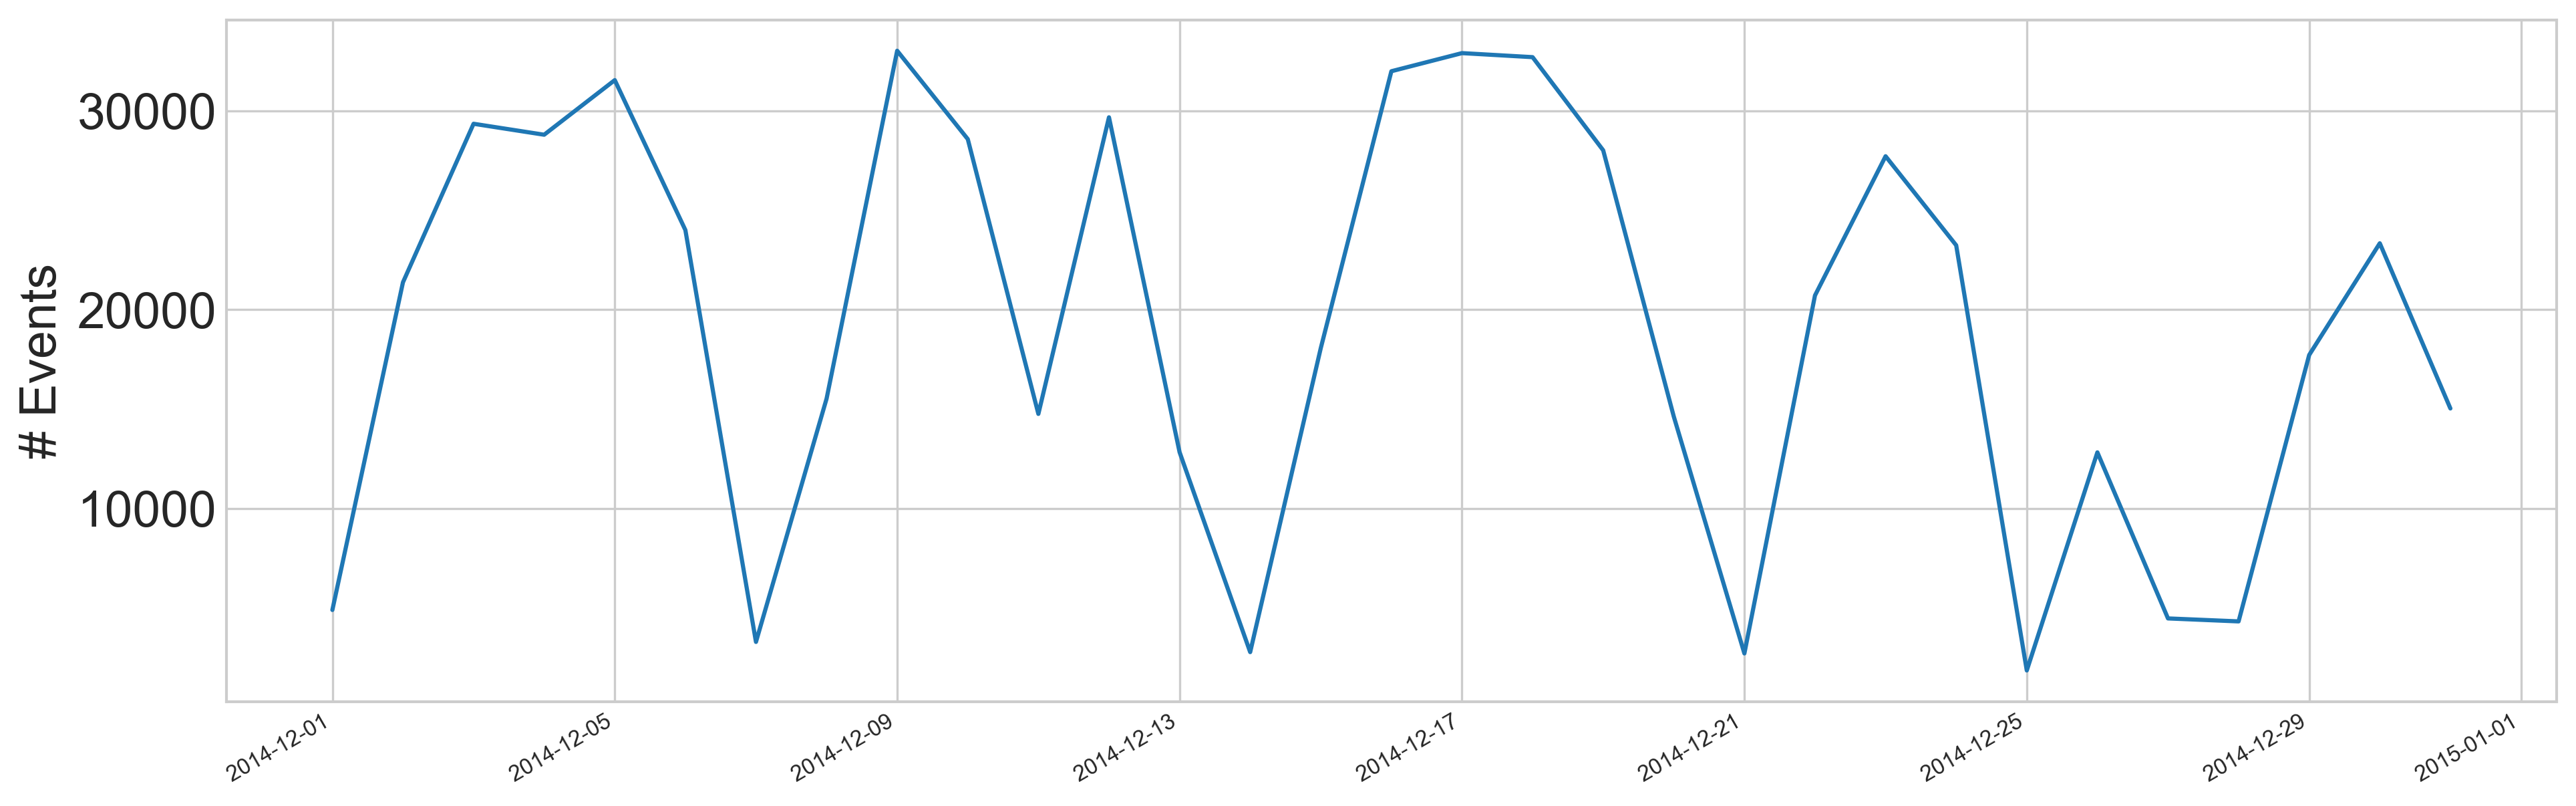

In [9]:
plt.subplots(figsize=(15, 5))
date_count = df['date'].value_counts().plot(kind="line")
plt.ylabel('# Events')
plt.show()

Let's look at impact of day of week

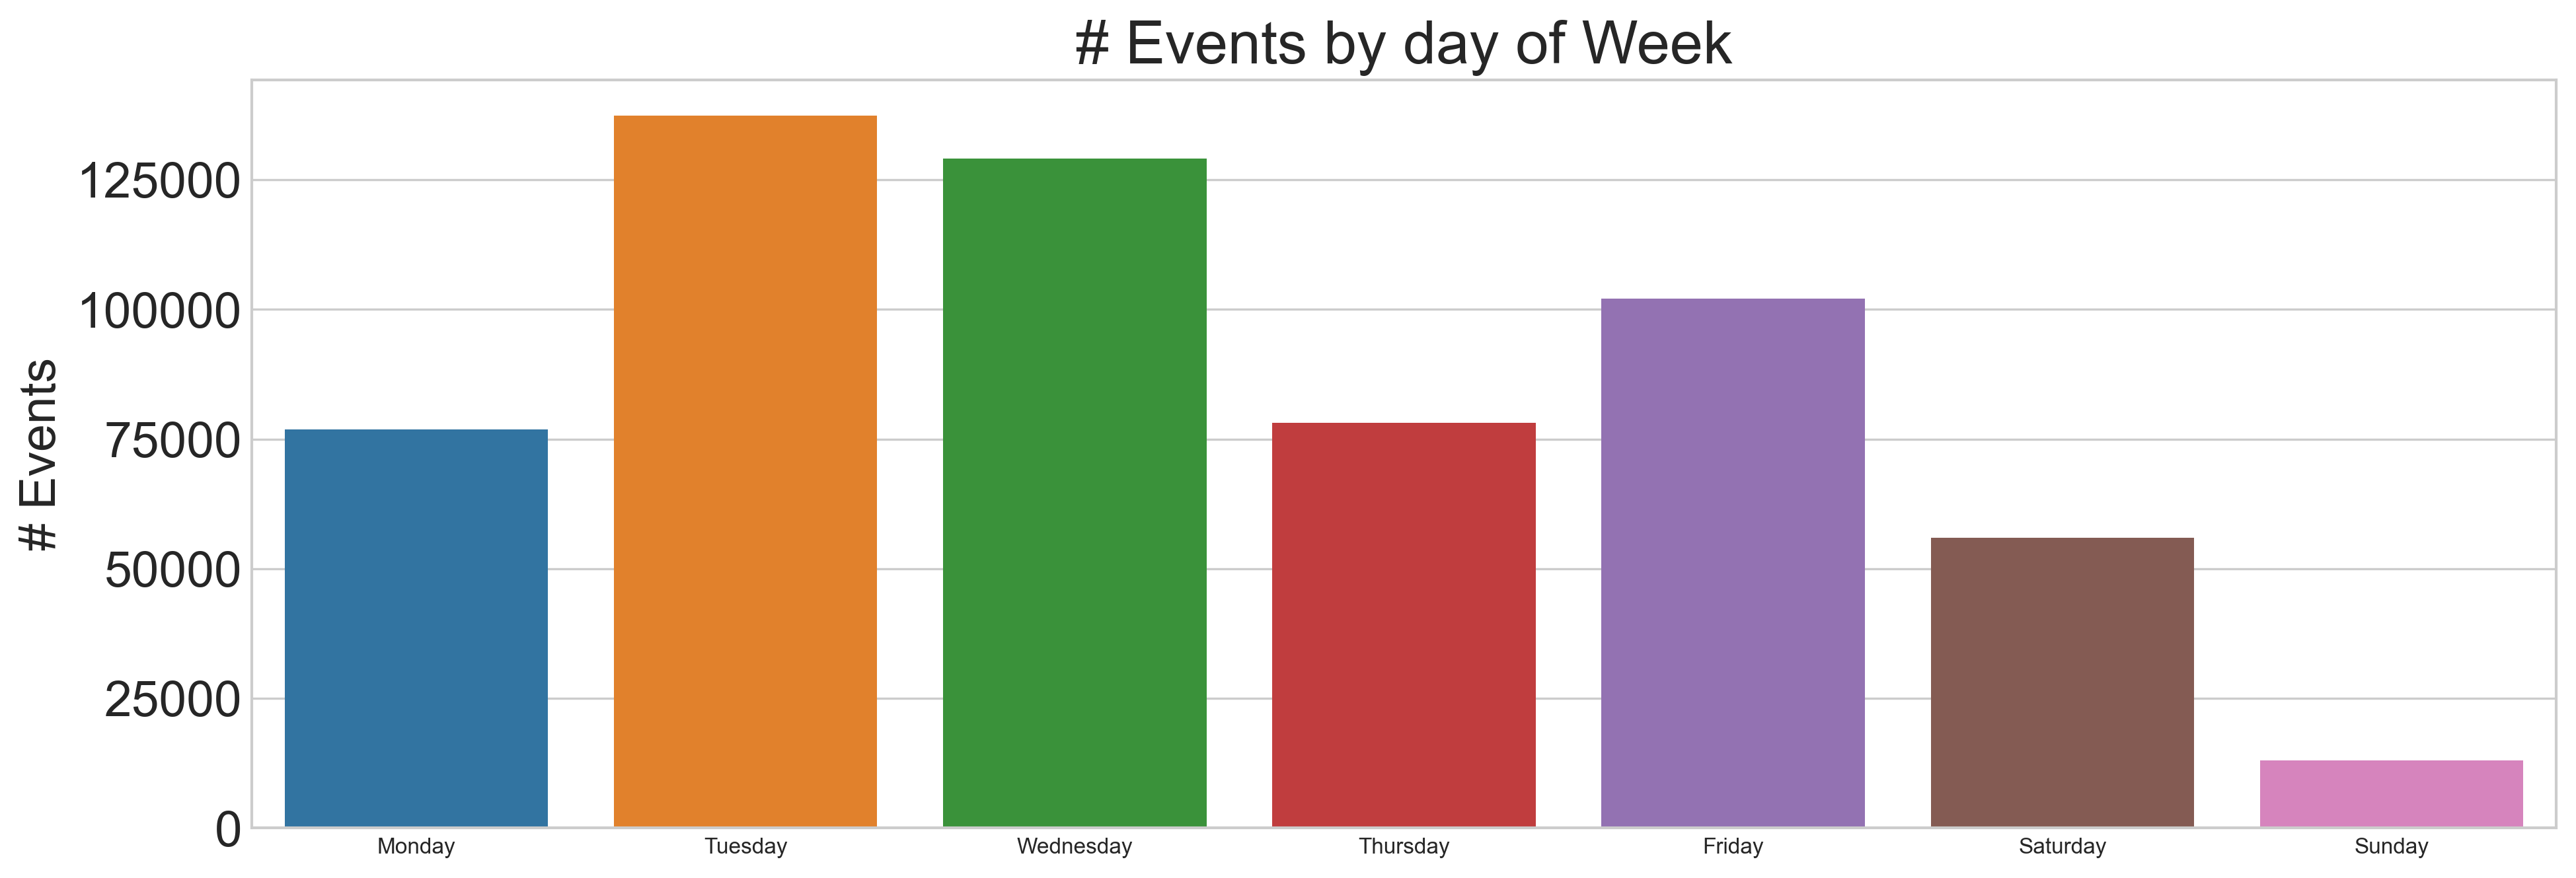

In [10]:
df['weekday'] = df['date'].dt.day_name() #create new column for weekday
df['dayofweek'] = df.time_string.dt.dayofweek #create new column for weekday number (Monday=0 ..., Sunday=6)

# Create summary stats grouped by week day
date_sum = df.groupby(['weekday','dayofweek']).agg({'event': 'count',
                          'instance':['nunique'],
                          'username':['nunique']
                         }).reset_index()

date_sum.columns = date_sum.columns.droplevel(level=1) # Drop a level so there is only one index
date_sum = date_sum.sort_values(by='dayofweek')
date_sum['event_per_user'] = date_sum['event'] / date_sum['username']

#print(date_sum)

plt.subplots(figsize=(15, 5))
sns.barplot(data=date_sum, x="weekday", y="event")
plt.title('# Events by day of Week')
plt.xlabel(None)
plt.ylabel('# Events')
# Put the legend out of the figure
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()




Interestingly we are getting about half the volume of events on Monday compared to Tuesdays. This is possible given the low sample sizes or there could be something else going on.
Also interesting that we are getting reasonable amounts of volume on Saturdays.

Let's now look at time of day patterns

&nbsp; 


In [11]:
df_time = df  #copy dataframe

df_time['hour'] = df.time_string.dt.hour #extract hour and store in new column

# group by day and hour
date_sum = df_time.groupby(['weekday','dayofweek','hour']).agg({'event': 'count',
                          'instance':['nunique'],
                          'username':['nunique']
                         }).reset_index()

date_sum.columns = date_sum.columns.droplevel(level=1) # Drop a level so there is only one index
date_sum = date_sum.sort_values(by='dayofweek')

#df_time.sort_values(by=).head()
ct = pd.crosstab([date_sum.dayofweek, date_sum.weekday], date_sum.hour, aggfunc='sum', values=date_sum.event, normalize=True).\
style.background_gradient(cmap='hot_r')
ct.format('{:.3f}')

Looking at user volumes above, we can't see a clear workday pattern of 9am-5pm. 

As our time is based on UTC, we would need to convert these timestamps to the country these users are based in. Without this information, I have left the time stamps as is for now.

&nbsp; 

##  2. Compare users "778251ffec35de6bbbb089198b9ac516" and "7e7a085a9f6f55253b2aa15dbcb702a8" from the instance "c93da7e17688ef90fc43963b5a6c6259"; would you conclude their average number of events per day to be different? Justify your answer.

&nbsp; 



In [12]:
# Let's first filter the dataset for above instance and users
df2 = df[(df.instance == 'c93da7e17688ef90fc43963b5a6c6259') & (df.username == '778251ffec35de6bbbb089198b9ac516') | (df.username == '7e7a085a9f6f55253b2aa15dbcb702a8')]
df2.head()
#df2.info()

time_string      unix_time                          instance  \
948 2014-12-01 17:33:15.849  1417415595849  c93da7e17688ef90fc43963b5a6c6259   
949 2014-12-01 17:33:15.849  1417415595849  c93da7e17688ef90fc43963b5a6c6259   
950 2014-12-01 17:33:15.850  1417415595850  c93da7e17688ef90fc43963b5a6c6259   
951 2014-12-01 17:33:20.183  1417415600183  c93da7e17688ef90fc43963b5a6c6259   
952 2014-12-01 17:33:20.184  1417415600184  c93da7e17688ef90fc43963b5a6c6259   

    product                          username  \
948    jira  778251ffec35de6bbbb089198b9ac516   
949    jira  778251ffec35de6bbbb089198b9ac516   
950    jira  778251ffec35de6bbbb089198b9ac516   
951    jira  778251ffec35de6bbbb089198b9ac516   
952    jira  778251ffec35de6bbbb089198b9ac516   

                                     event  \
948                      kickass.viewIssue   
949      kickass.criteriaAutoUpdateEnabled   
950                      browserWindowSize   
951             browser.metrics.navigation   
952  browser.metrics.secureConnectionStart   

                                            attributes       date weekday  \
948  {'context_pageSession': 'c8950665dbc8dde1ddec4... 2014-12-01  Monday   
949  {'context_pageTime': '3201351c5b93c382611b102c... 2014-12-01  Monday   
950  {'width': '277e5a0cce38df6d6f70ce768896f544', ... 2014-12-01  Monday   
951  {'secureConnectionStart': '553243b592c858d01c1... 2014-12-01  Monday   
952  {'version': 'a4a93554fdaaa36a86f392a3592ab1c2'... 2014-12-01  Monday   

     dayofweek  hour  
948          0    17  
949          0    17  
950          0    17  
951          0    17  
952          0    17

&nbsp; 

Now let's explore the behaviour of these 2 users in more detail:




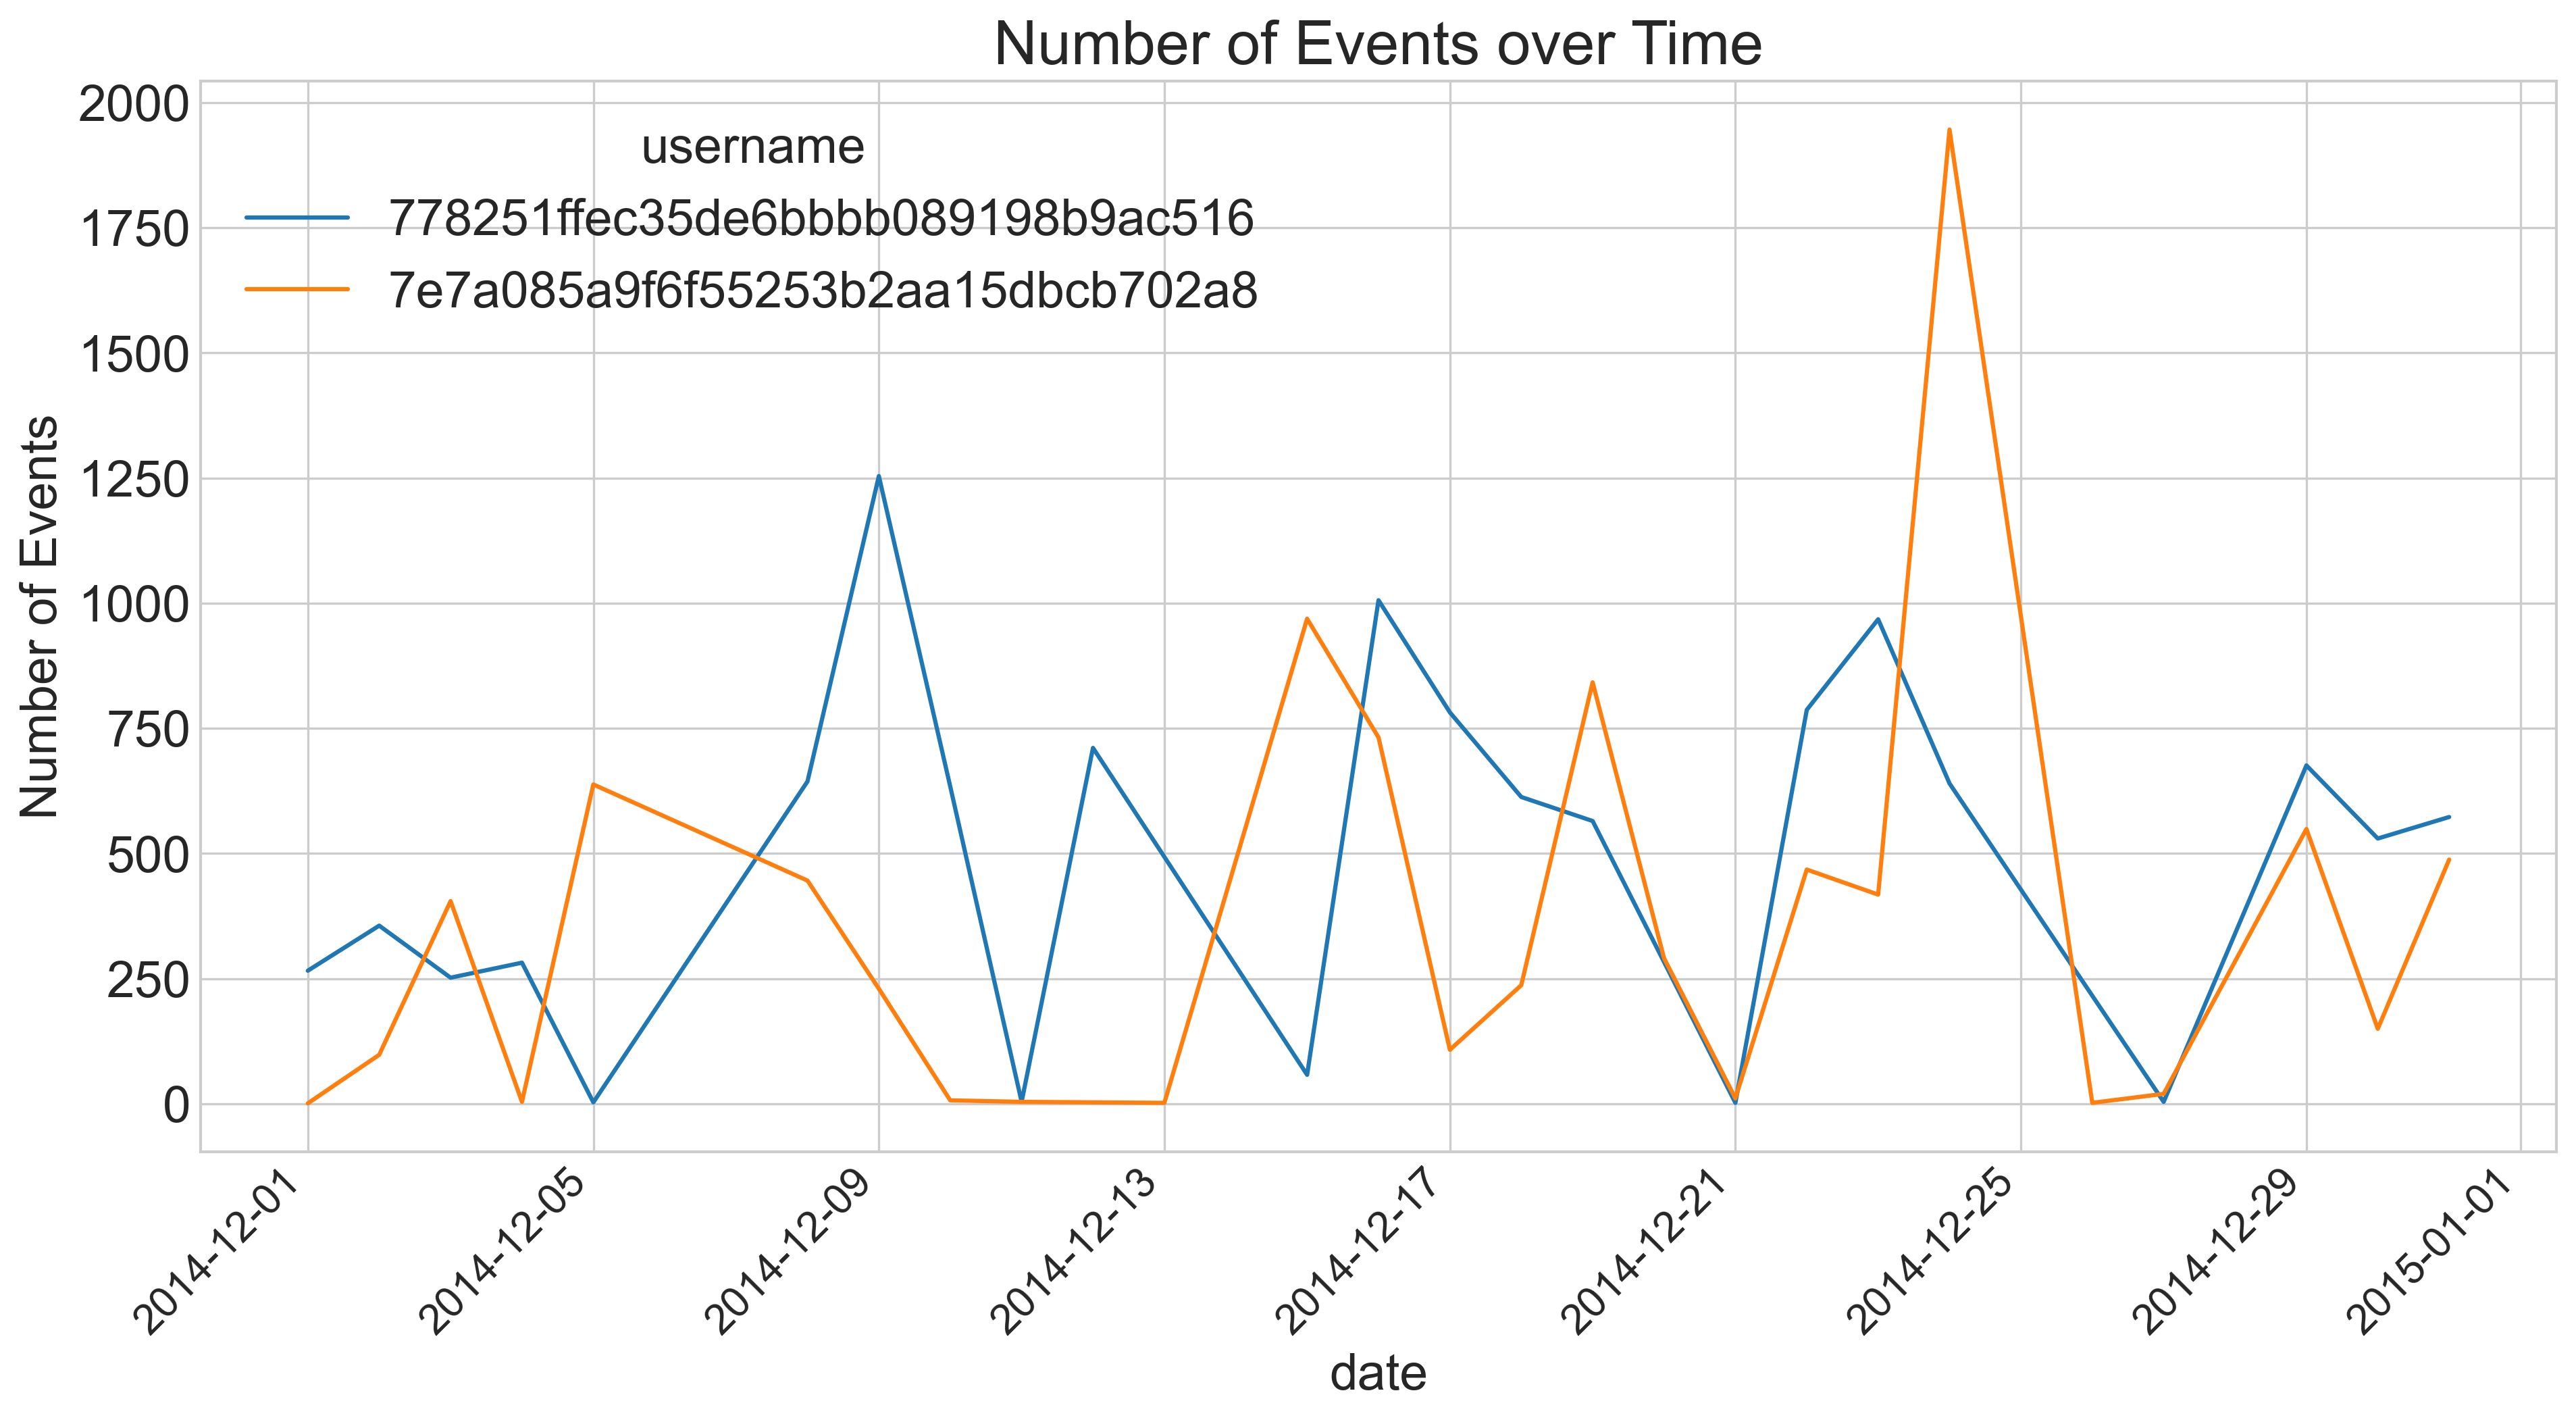

In [13]:
sdf_grouped =  sqldf("select date, username, count(*) as cnt from df2 group by 1,2")
sdf_grouped['date']= pd.to_datetime(sdf_grouped['date']).dt.date # clean up date field

plt.figure(figsize=(15,7))
sns.lineplot(x="date", y="cnt", hue="username", data=sdf_grouped)
plt.ylabel('Number of Events')
plt.title('Number of Events over Time')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
#plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Put the legend out of the figure
plt.show()

It looks like the daily count of events by user is quite volatile with some days with little to no usage and others with more than a thousand events.

Let's explore in more detail...

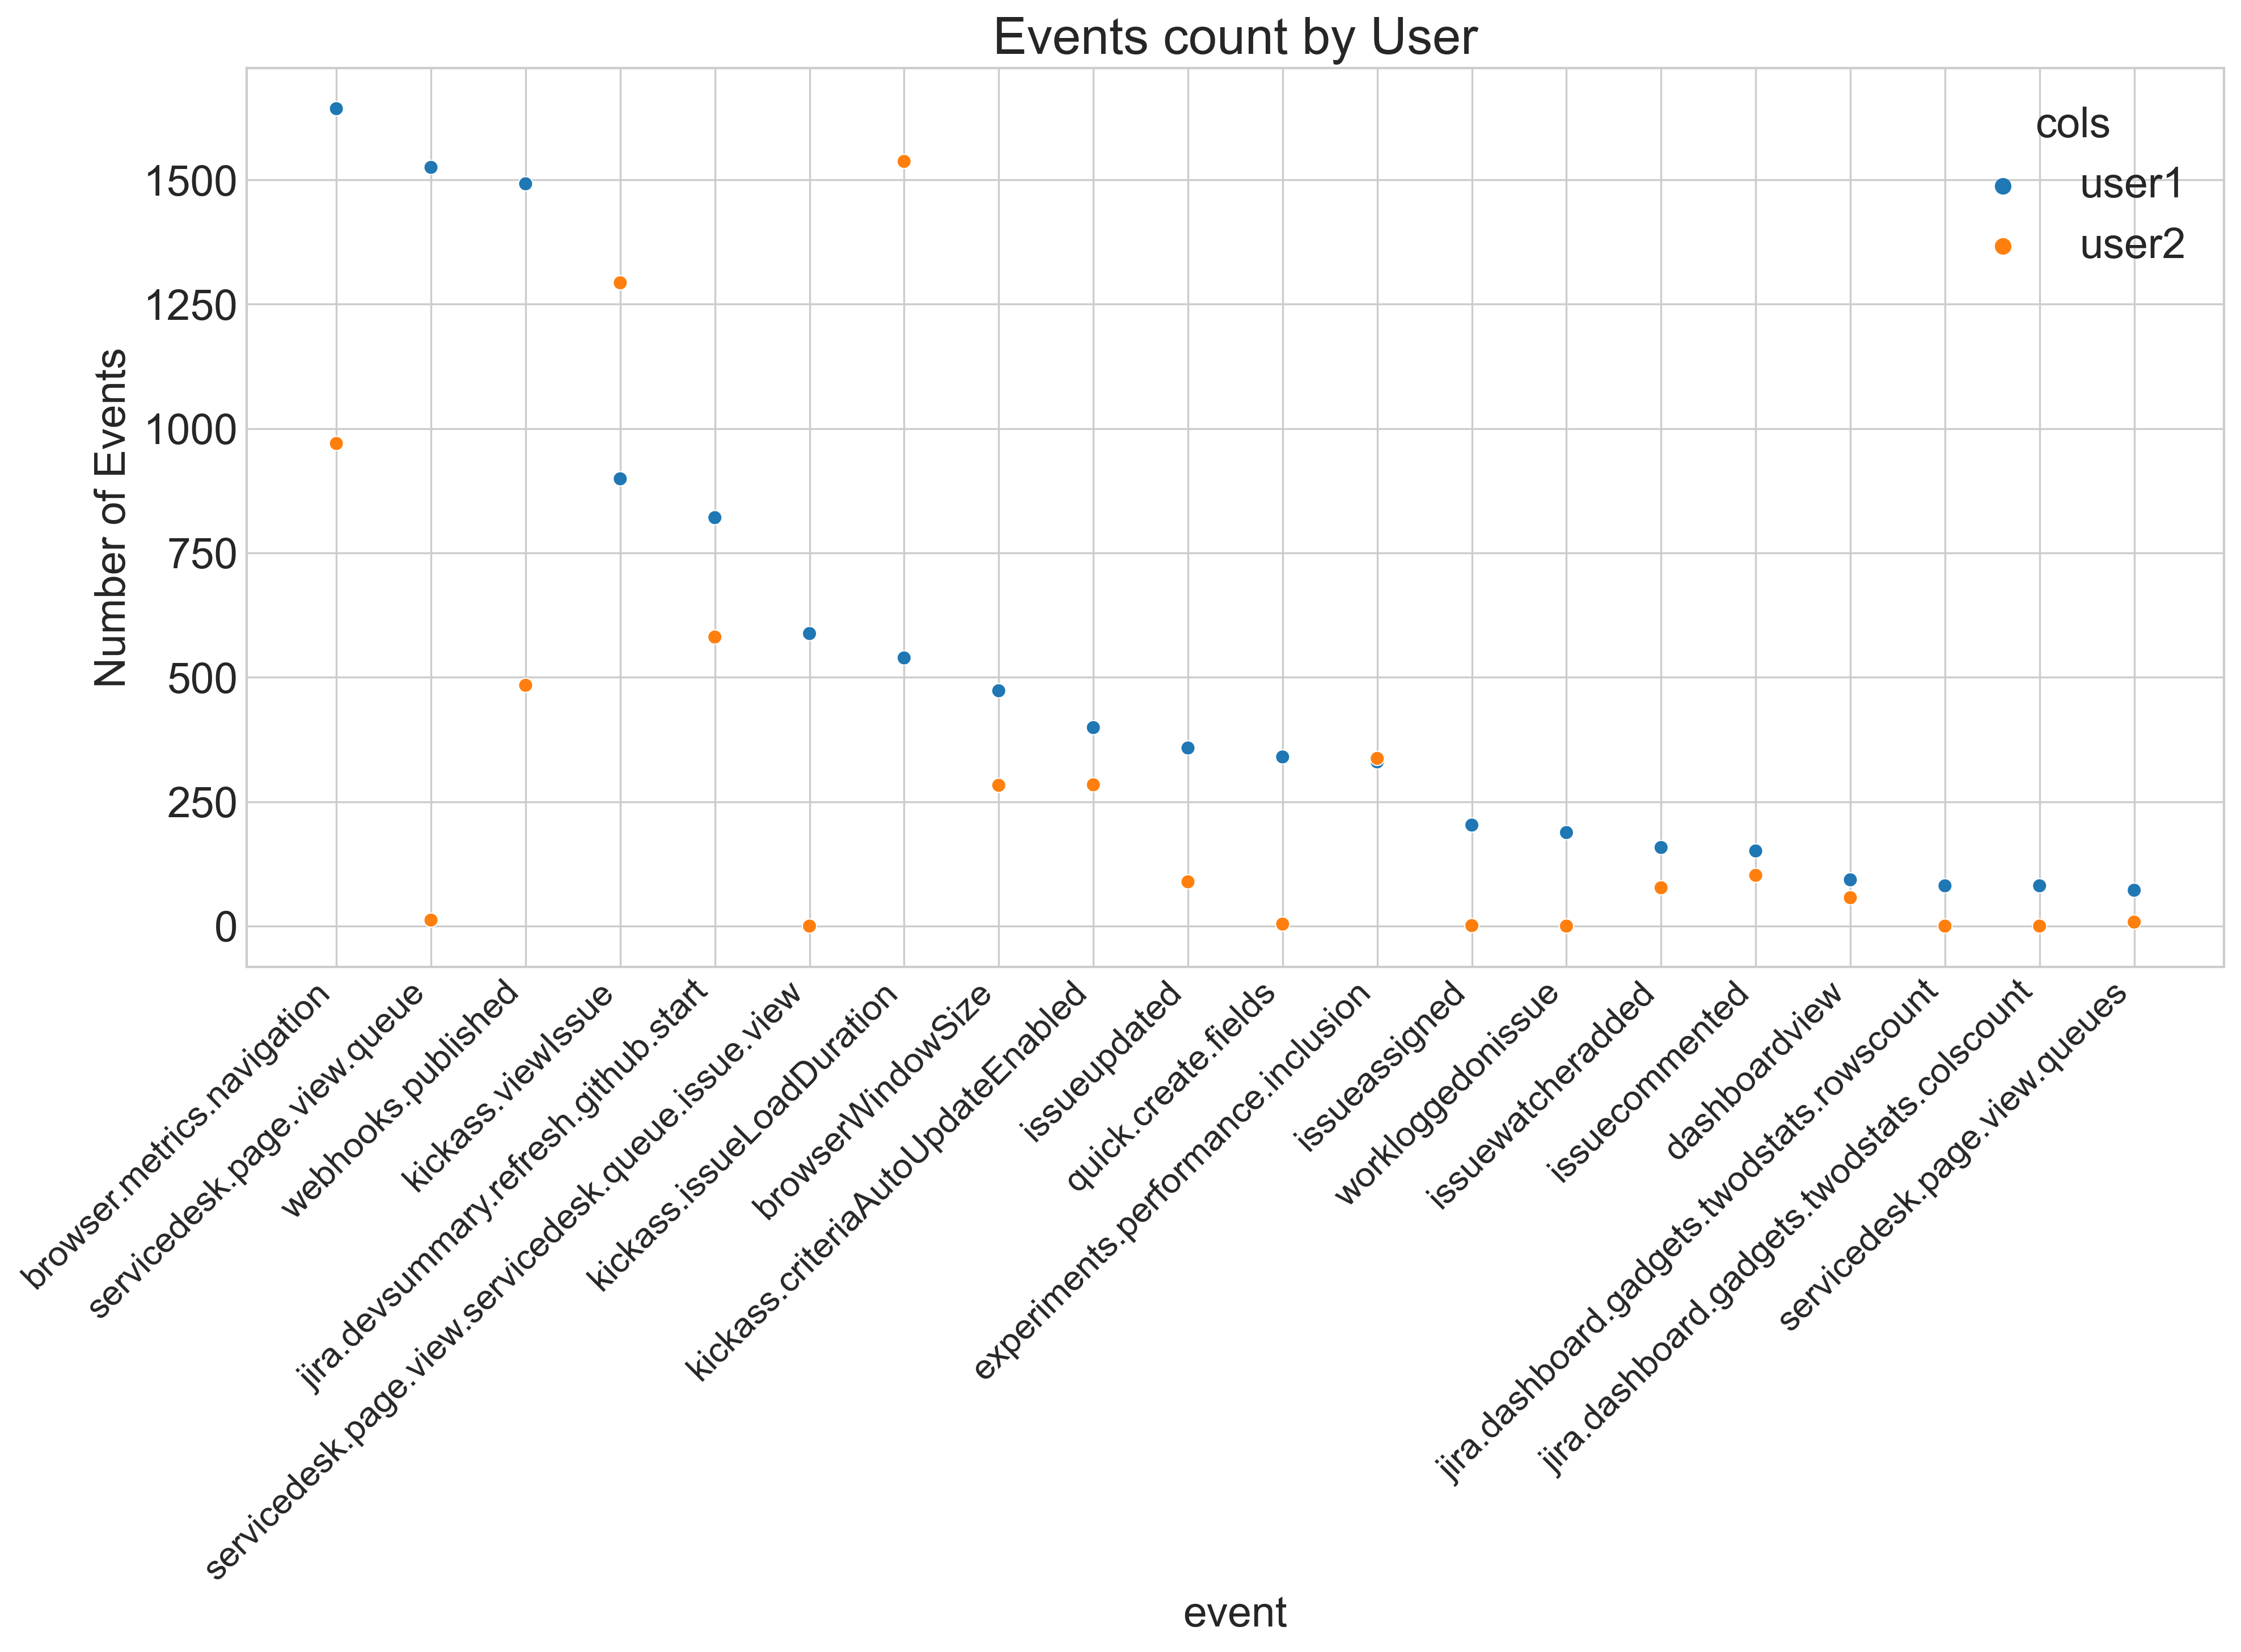

In [14]:
# Let's look at the type of events the users are engaged in

sdf_grouped_event = sqldf("select event, count(case when username='778251ffec35de6bbbb089198b9ac516' then 1 else null end) as user1, count(case when username='7e7a085a9f6f55253b2aa15dbcb702a8' then 1 else null end) as user2 from df2 group by 1 order by 2 desc limit 20")
#print(sdf_grouped_event)
sdf_melt = sdf_grouped_event.melt('event', var_name='cols',  value_name='vals')

plt.figure(figsize=(15,7))
x = sns.scatterplot(x="event", y="vals", hue='cols', data=sdf_melt)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
#plt.tight_layout()
plt.title('Events count by User')
plt.ylabel('Number of Events')
plt.show()

It looks like the 2 users are engaged in broadly different event types. For the purpose of this simple exercise we will ignore any differences in event type and assume all events have equal importance.

Now, let's look at the distribution of daily events by user...

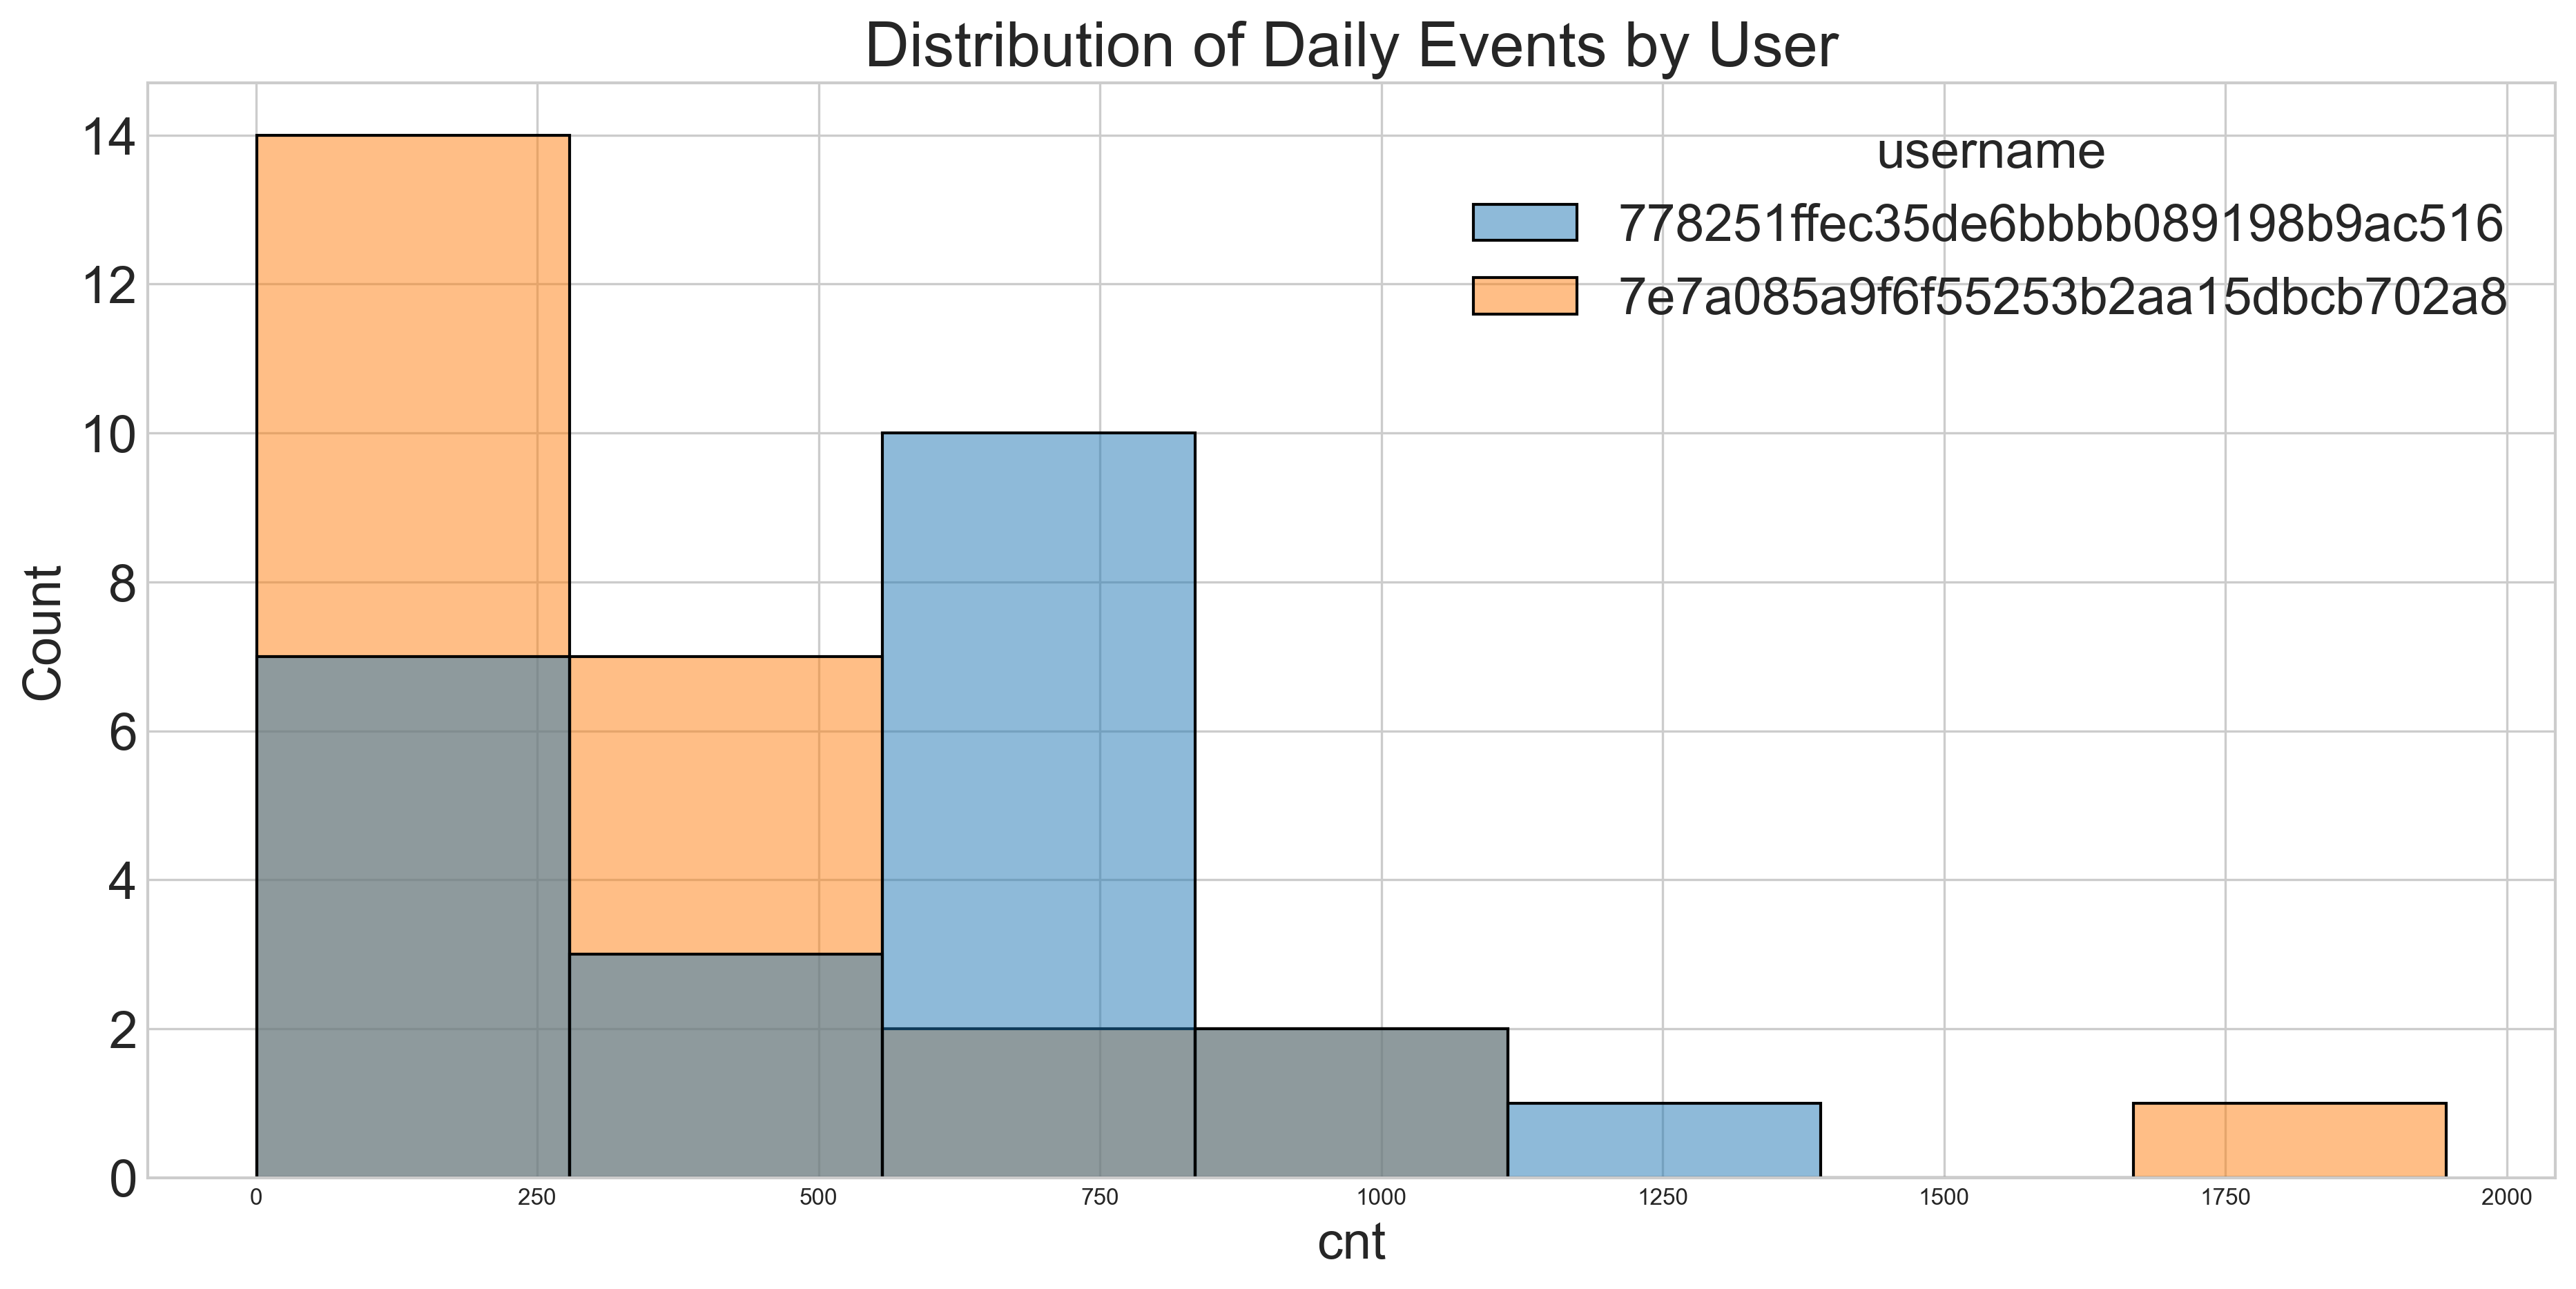

In [15]:
plt.figure(figsize=(15,7))
sns.histplot(sdf_grouped, x="cnt", hue="username")
#sns.displot(sdf_grouped, x="cnt", hue="username", multiple="stack")
plt.title('Distribution of Daily Events by User')
plt.show()


Here we can see quite a different distribution for the 2 users with user 2 having a left tail distribution and user 1 resembling more of a normal distribution.

It should be noted, the data looks like sparse for both users.

Let's look at the boxplots

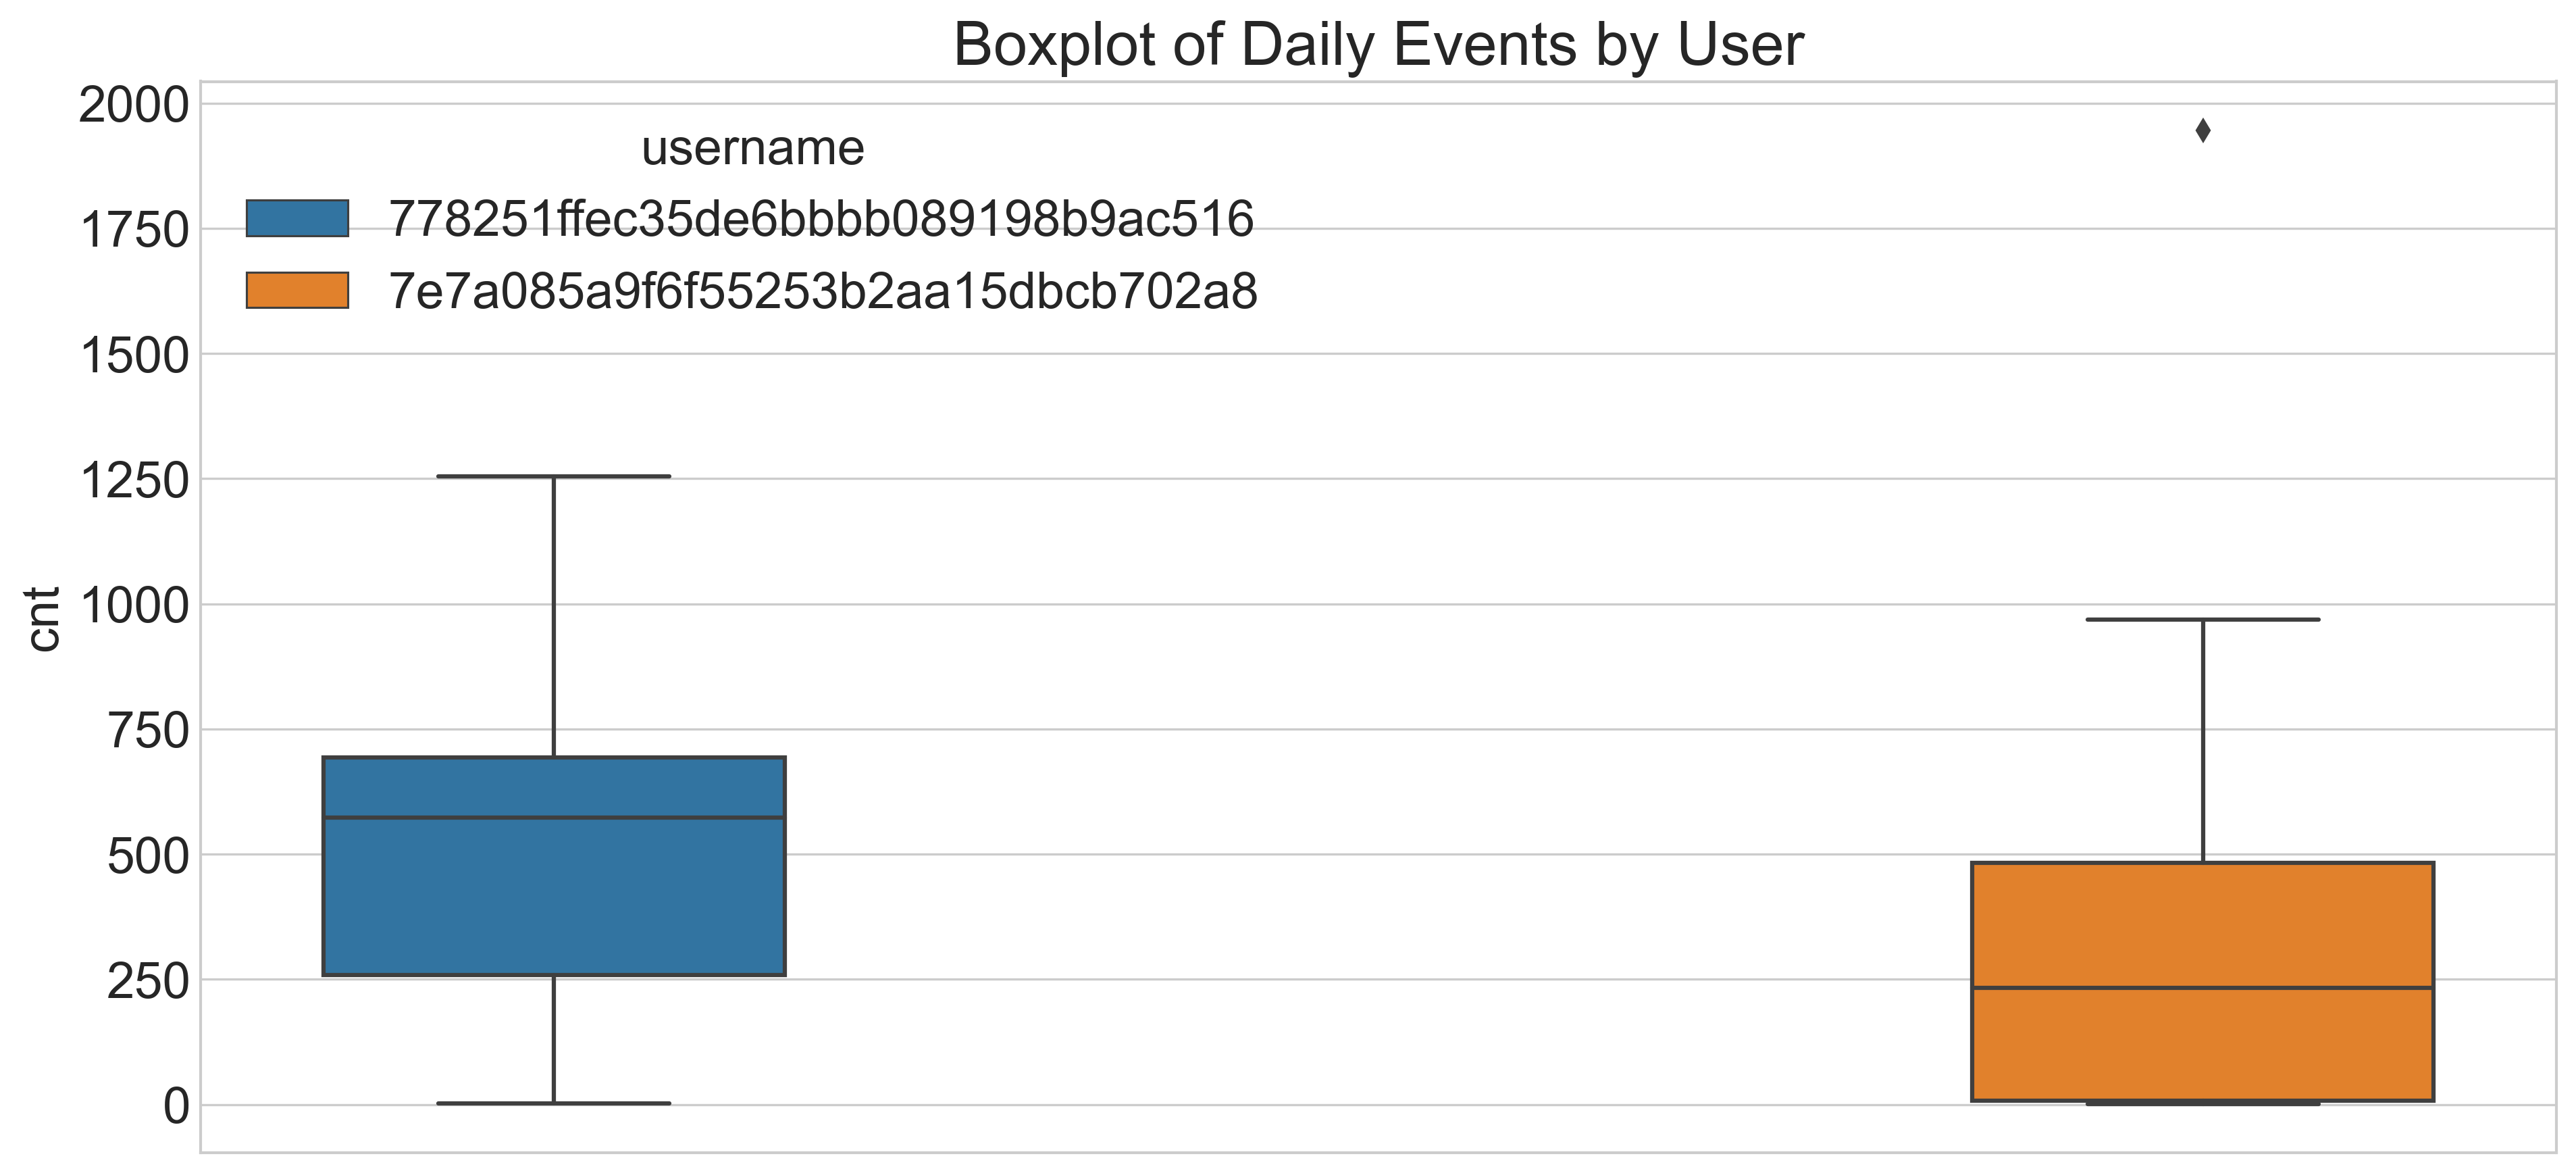

In [16]:
plt.figure(figsize=(15,7))
sns.boxplot(x="username", y="cnt", hue="username", data=sdf_grouped).axes.xaxis.set_visible(False)
plt.title('Boxplot of Daily Events by User')
plt.show()

&nbsp; 

Visually, we can observe quite a few differences between the distributions of event per day for the 2 users.

Now we can look at testing these differences with an appropriate statistical test.

Since we are dealing with means and we do not know the population distribution, we will use a 2 sample t-test:

- **Null Hypothesis (H0)**: The average number of daily events per user are the same between the 2 users. 
- **Alternative Hypothesis (HA)**: The average number of daily events per user are NOT the same between the 2 users. 




In [17]:
# We will create our data structure and separate out each user's daily event counts in a new column
sdf_user =  sqldf("select date, count(case when username='778251ffec35de6bbbb089198b9ac516' then 1 else null end) as user1, count(case when username='7e7a085a9f6f55253b2aa15dbcb702a8' then 1 else null end) as user2 from df2 group by 1")
sdf_user['date']= pd.to_datetime(sdf_user['date']).dt.date # clean up date field

In [18]:
sdf_user.describe()

user1        user2
count    26.000000    26.000000
mean    446.538462   348.807692
std     369.058178   435.832263
min       0.000000     1.000000
25%      17.500000     8.000000
50%     547.500000   233.500000
75%     668.000000   483.000000
max    1254.000000  1946.000000

Looking at user top level statistics, it looks like user 1: `778251ffec35de6bbbb089198b9ac516` has a higher daily average, however we cannot conclude a difference quite yet.

We can also note the relatively high standard deviation for both users.

Let's now run our t-test:

In [19]:
from scipy.stats import ttest_ind
from numpy import std, mean, sqrt, var
from statsmodels.stats.power import TTestIndPower

# t-test 2 sided

# we are going to assume an industry standard level of sig 5%
alpha = 0.05 

stat, p = ttest_ind(sdf_user['user1'], sdf_user['user2']) 
#note: we don't have information on whether the variance from the distributions are equal so we have left out this paramter

print('T-stat=%.3f, p=%.3f' % (stat, p))
if p > alpha:
	print('Do not reject H0')
else:
	print('Reject H0')

# calculate cohen's d, a standardised measure of distance between 2 means
def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (mean(x) - mean(y)) / sqrt(((nx-1)*std(x, ddof=1) ** 2 + (ny-1)*std(y, ddof=1) ** 2) / dof)

d = cohen_d(sdf_user['user1'], sdf_user['user2'])
print('Cohens d: %.3f' % d)

# perform power analysis to understand type 2 error
analysis = TTestIndPower()
result = analysis.solve_power(d, power=None, nobs1=len(sdf_user), ratio=1.0, alpha=0.05, alternative='two-sided')
print('Power: %.3f' % result)


T-stat=0.873, p=0.387
Do not reject H0
Cohens d: 0.242
Power: 0.137




From above t-test we can conclude our test does **not** have sufficient power.
i.e. there is only a 13.7% probability that we will be able to detect a significant difference between the 2 means. This gives us a Type 2 error probability of ~86% - a very high chance that we would not reject H0 when there is in fact a significant difference in the means.

&nbsp;

Let's look at what could be causing the low power...

In [20]:
# What is the minimum sample size required for 80% power
# note: we are choosing power=0.8 based on industry standards but this can easily be changed

analysis = TTestIndPower()
result = analysis.solve_power(d, power=0.8, nobs1=None, ratio=1.0, alpha=0.05, alternative='two-sided')
print('Minimum Sample Required: %.0f' % result)

Minimum Sample Required: 269


It  looks like the low sample size (n=26) is a factor in our low power.

In order to be able to detect a significant difference in the 2 means, we would need a sample of 269 days of event data per user. 

It should be noted, in practice this is a very long time to be running an experiment so we may want to engage our business stakeholders to understand the commercial requirements of this test and whether it's possible to find more users that can be added to the sample to reduce time required for the test.

Another option we have is to investigate other statistical tests that can deal more effectively with small sample sizes and high variance. I have not looked into due to time constraints.


&nbsp;


##  3.  Our users tend to use multiple features together when they use our products. Cluster events that tend to appear together into groups, and explain how and why you have clustered events in such a way.

&nbsp;

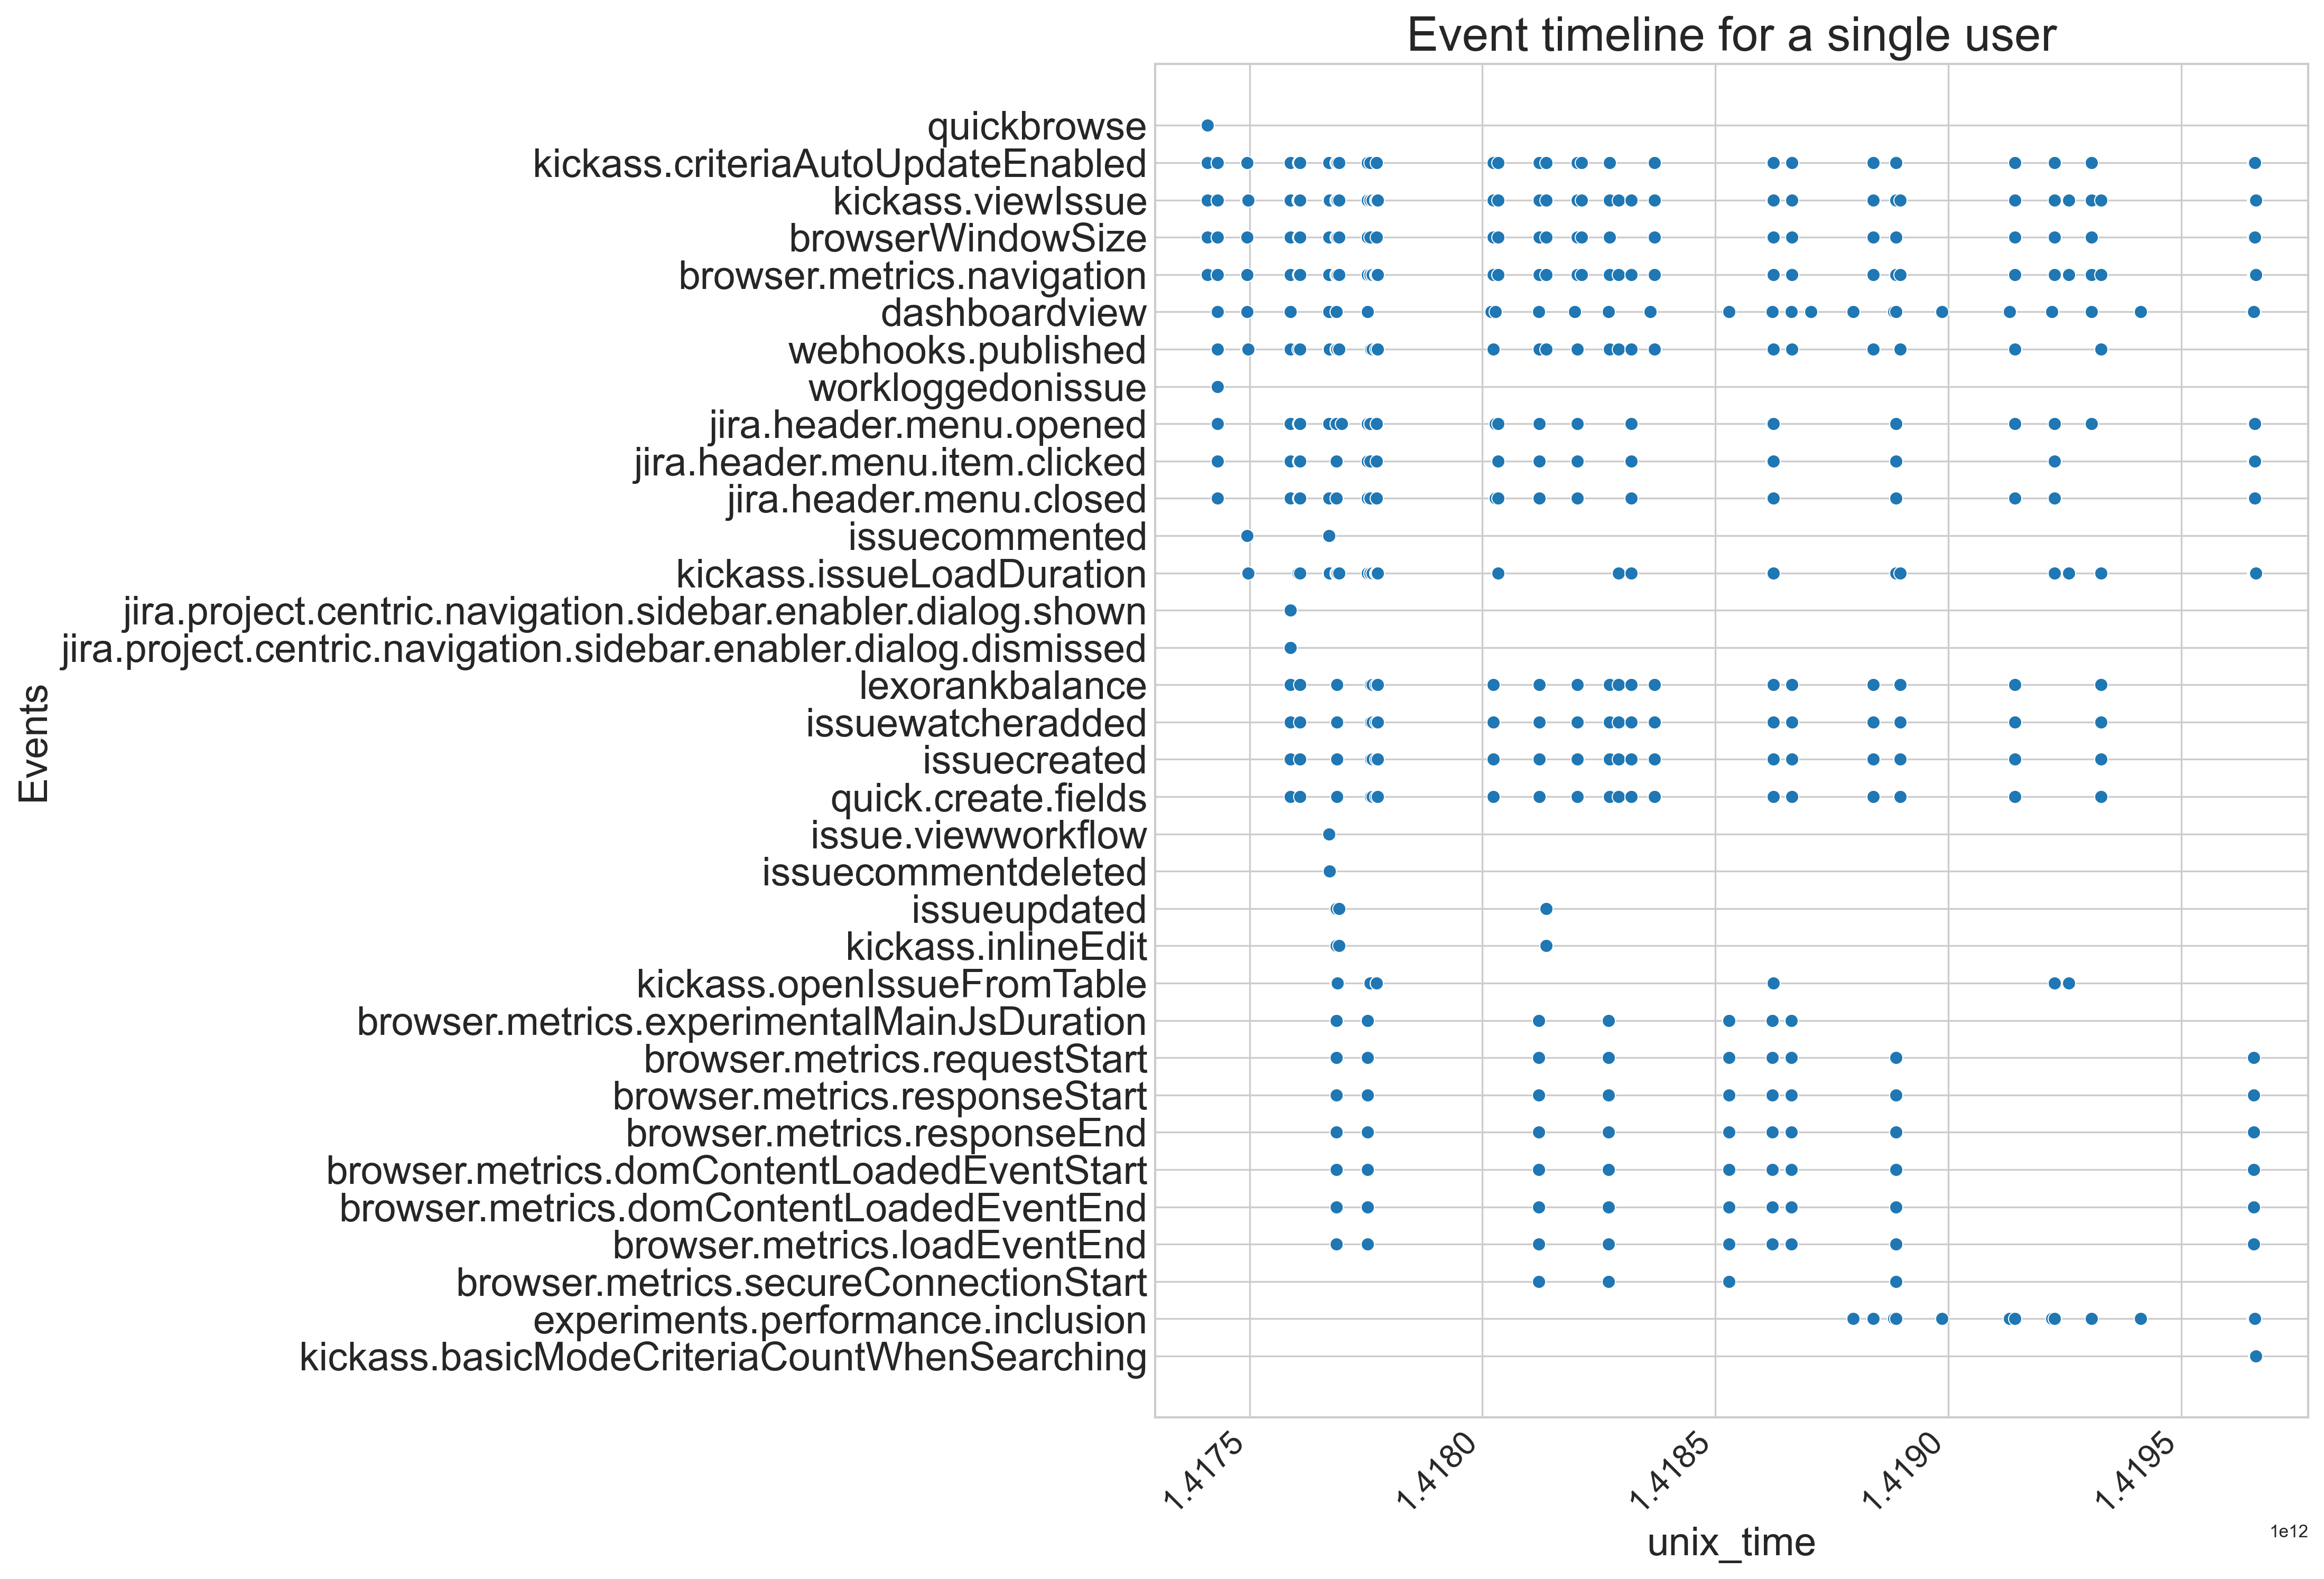

In [21]:
# Let's take a look at usage patterns for a single randomly selected user first

dfu = df[(df.username=='d50d63ec8ecdf32d1dd9ae4a0cecd2f8')]

plt.figure(figsize=(15,10))
x = sns.scatterplot(x="unix_time", y="event",data=dfu, legend=None)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
plt.tight_layout()
plt.title('Event timeline for a single user')
plt.ylabel('Events')
plt.show()

Looking at above chart we can see some clear patterns emerge with respect to events and time stamp.

Let's explore this relationship as a basis for a simple clustering algorithm below...

In [22]:
# A simple algorithm first for our single user.
# Logic: If an event is within x minutes of another then cluster together. 
# Keep repeating until the next event is further than x minutes

dfus = dfu[['username','time_string','unix_time', 'event']].sort_values(by='unix_time') #sort dataframe first
dfus['unix_time_diff_seconds'] = dfus['unix_time'].diff() / 1000 # calculate the difference between rows in seconds

# create a cluster group ID: one version version for 1 minute and another for 60 minutes
dfus['simple_clusters_1m'] = (dfus['unix_time_diff_seconds'] > 60).cumsum()  
dfus['simple_clusters_60m'] = (dfus['unix_time_diff_seconds'] > 60*60).cumsum()

# quick check our ID column works as expected
#dfus[['time_string','unix_time_diff_seconds','simple_clusters_1m','simple_clusters_60m']].head(15)

&nbsp;

Now, let's plot our simple clustering approach and compare to our original chart...


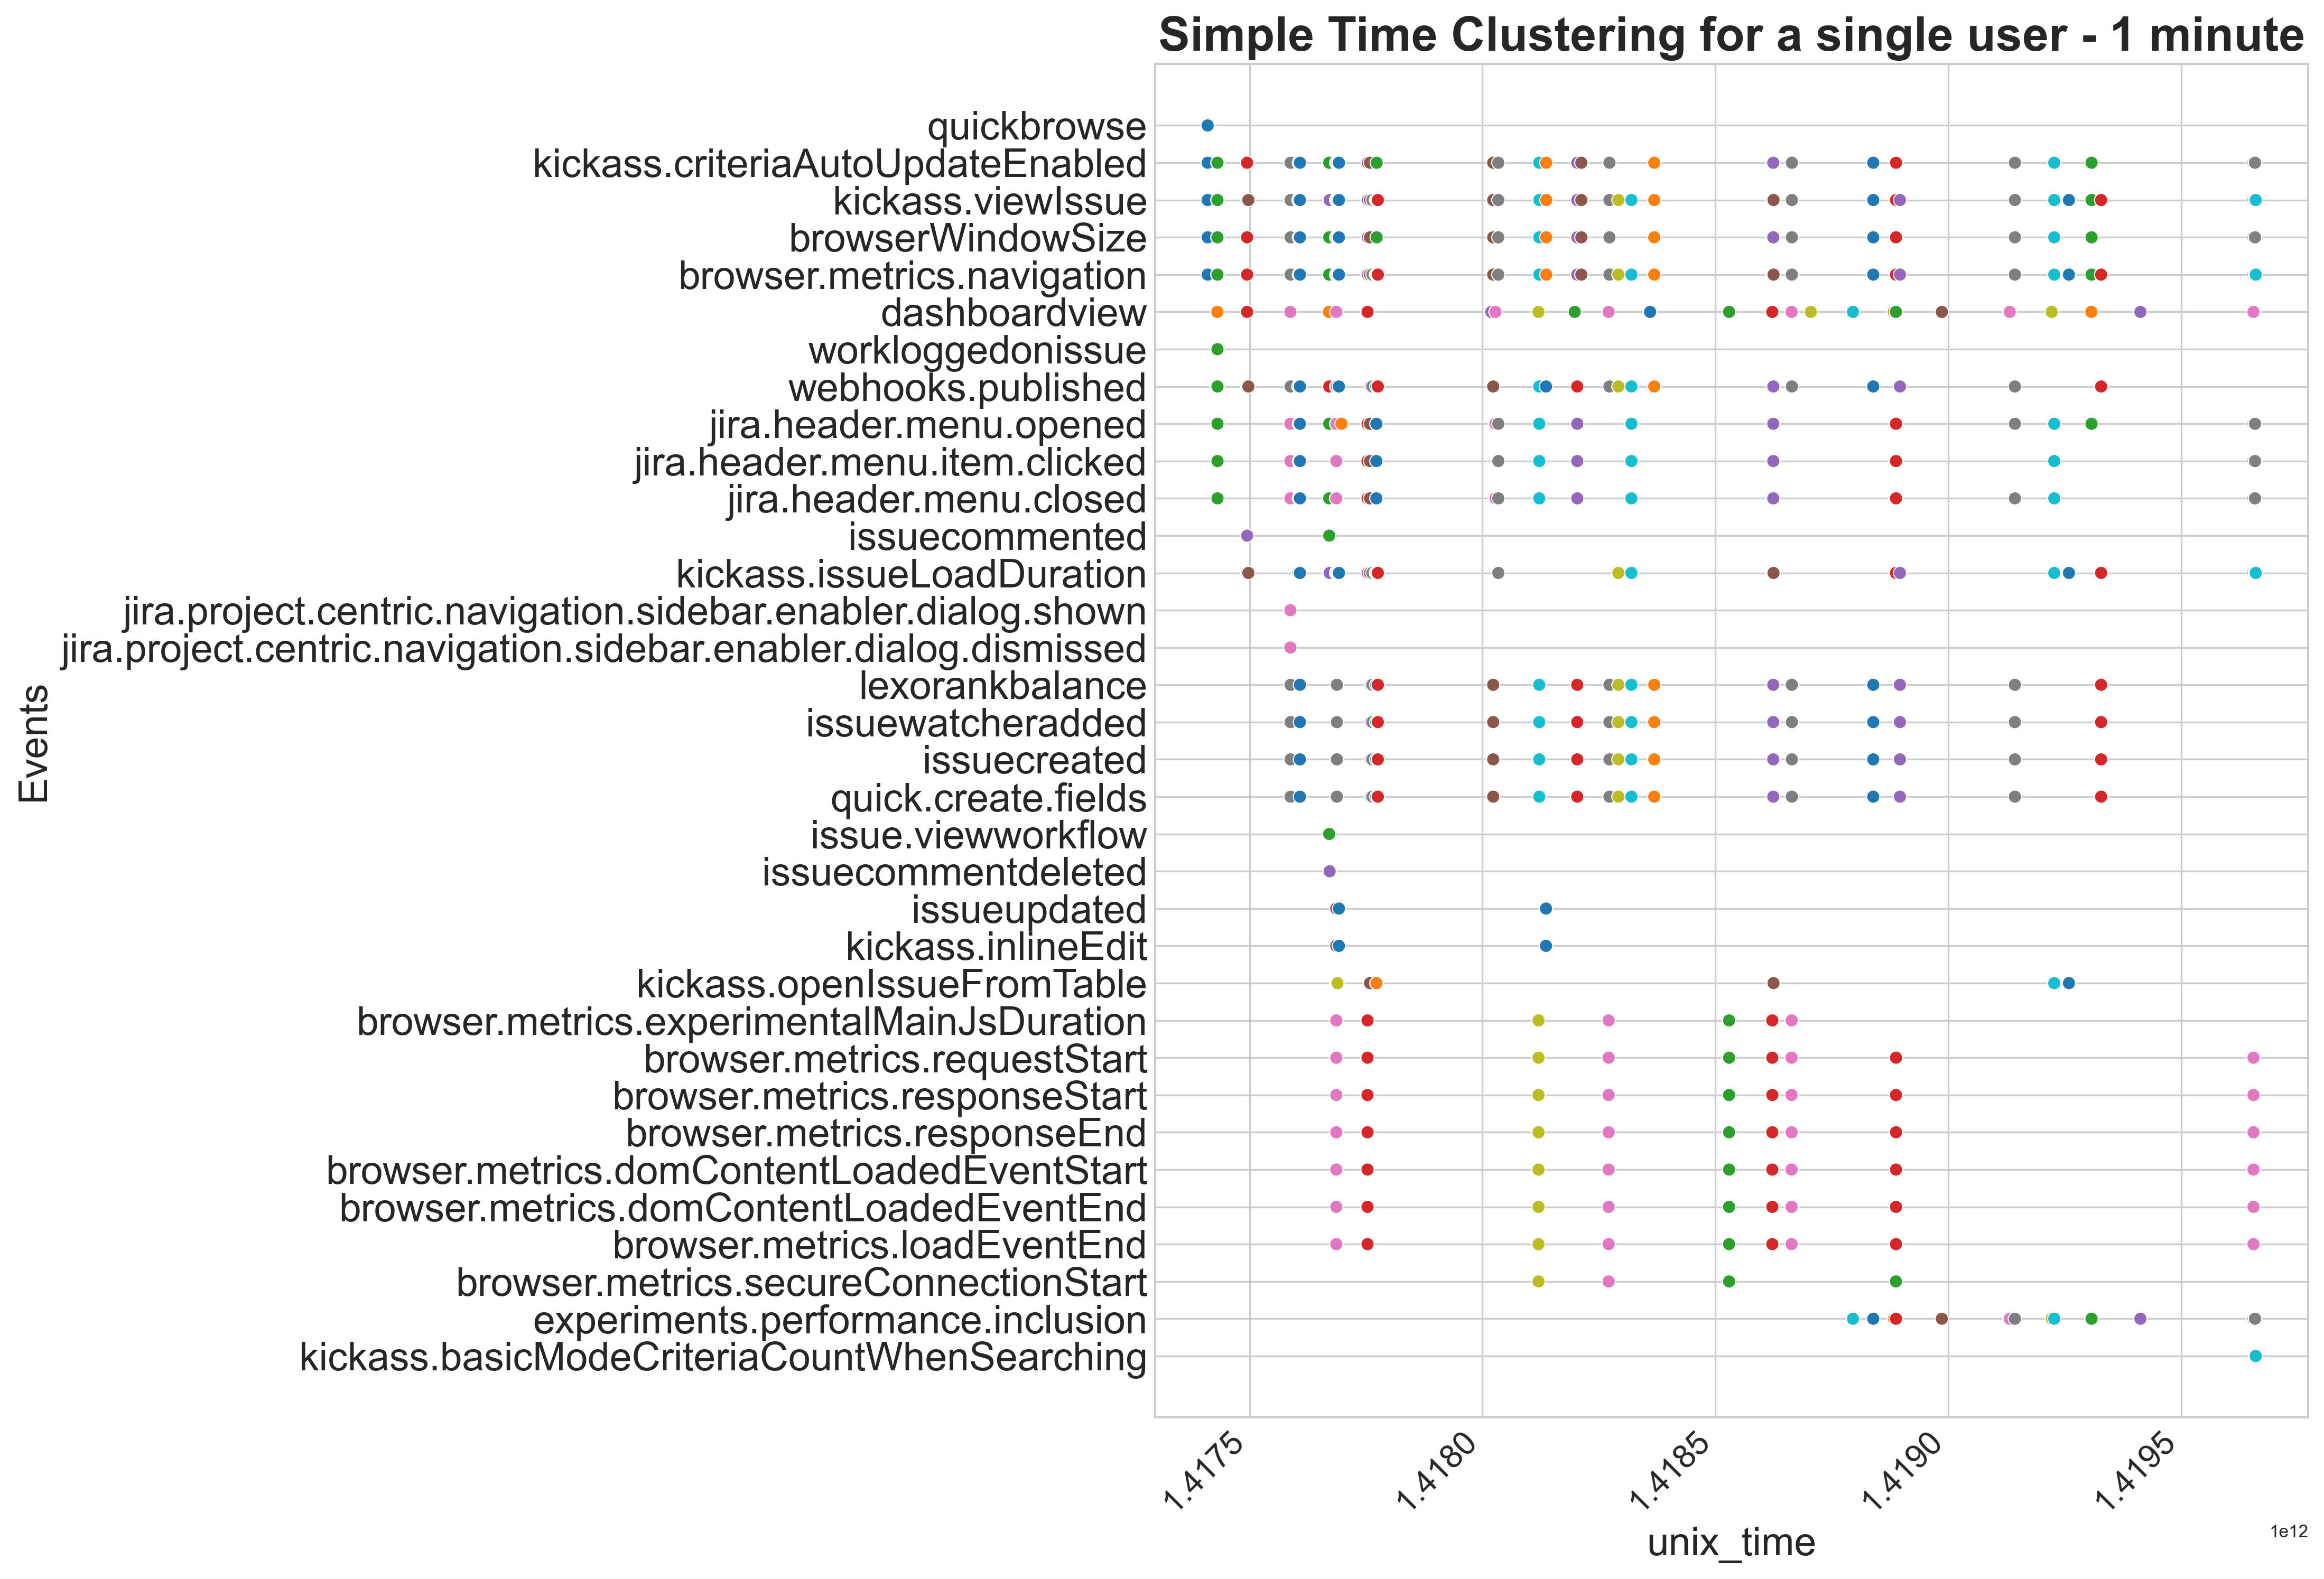

In [23]:
plt.figure(figsize=(15,10))
x = sns.scatterplot(x="unix_time", y="event", hue= 'simple_clusters_1m',data=dfus, legend=None, palette='tab10')

plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
plt.tight_layout()
plt.title('Simple Time Clustering for a single user - 1 minute', weight='bold')
plt.ylabel('Events')
plt.show()


We can see our first simple algorithm using 1 minute intervals has helped identify some clear patterns in the data. 

For example, we can see below events tend to accompany each other in quick succession. Perhaps these are related to a single user action of creating an issue.

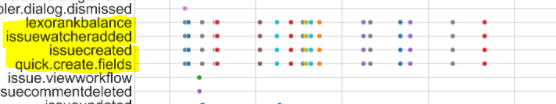



However, it's not clear whether this time window is appropriate for capturing events that go together.

Whilst we can do analysis into the time difference between events and choose the mean or median or some other measure, as we'll discuss below, it's best to understand business requirements before fine tuning and building complex models.

Let's have a look at a 60 minute interval for reference...

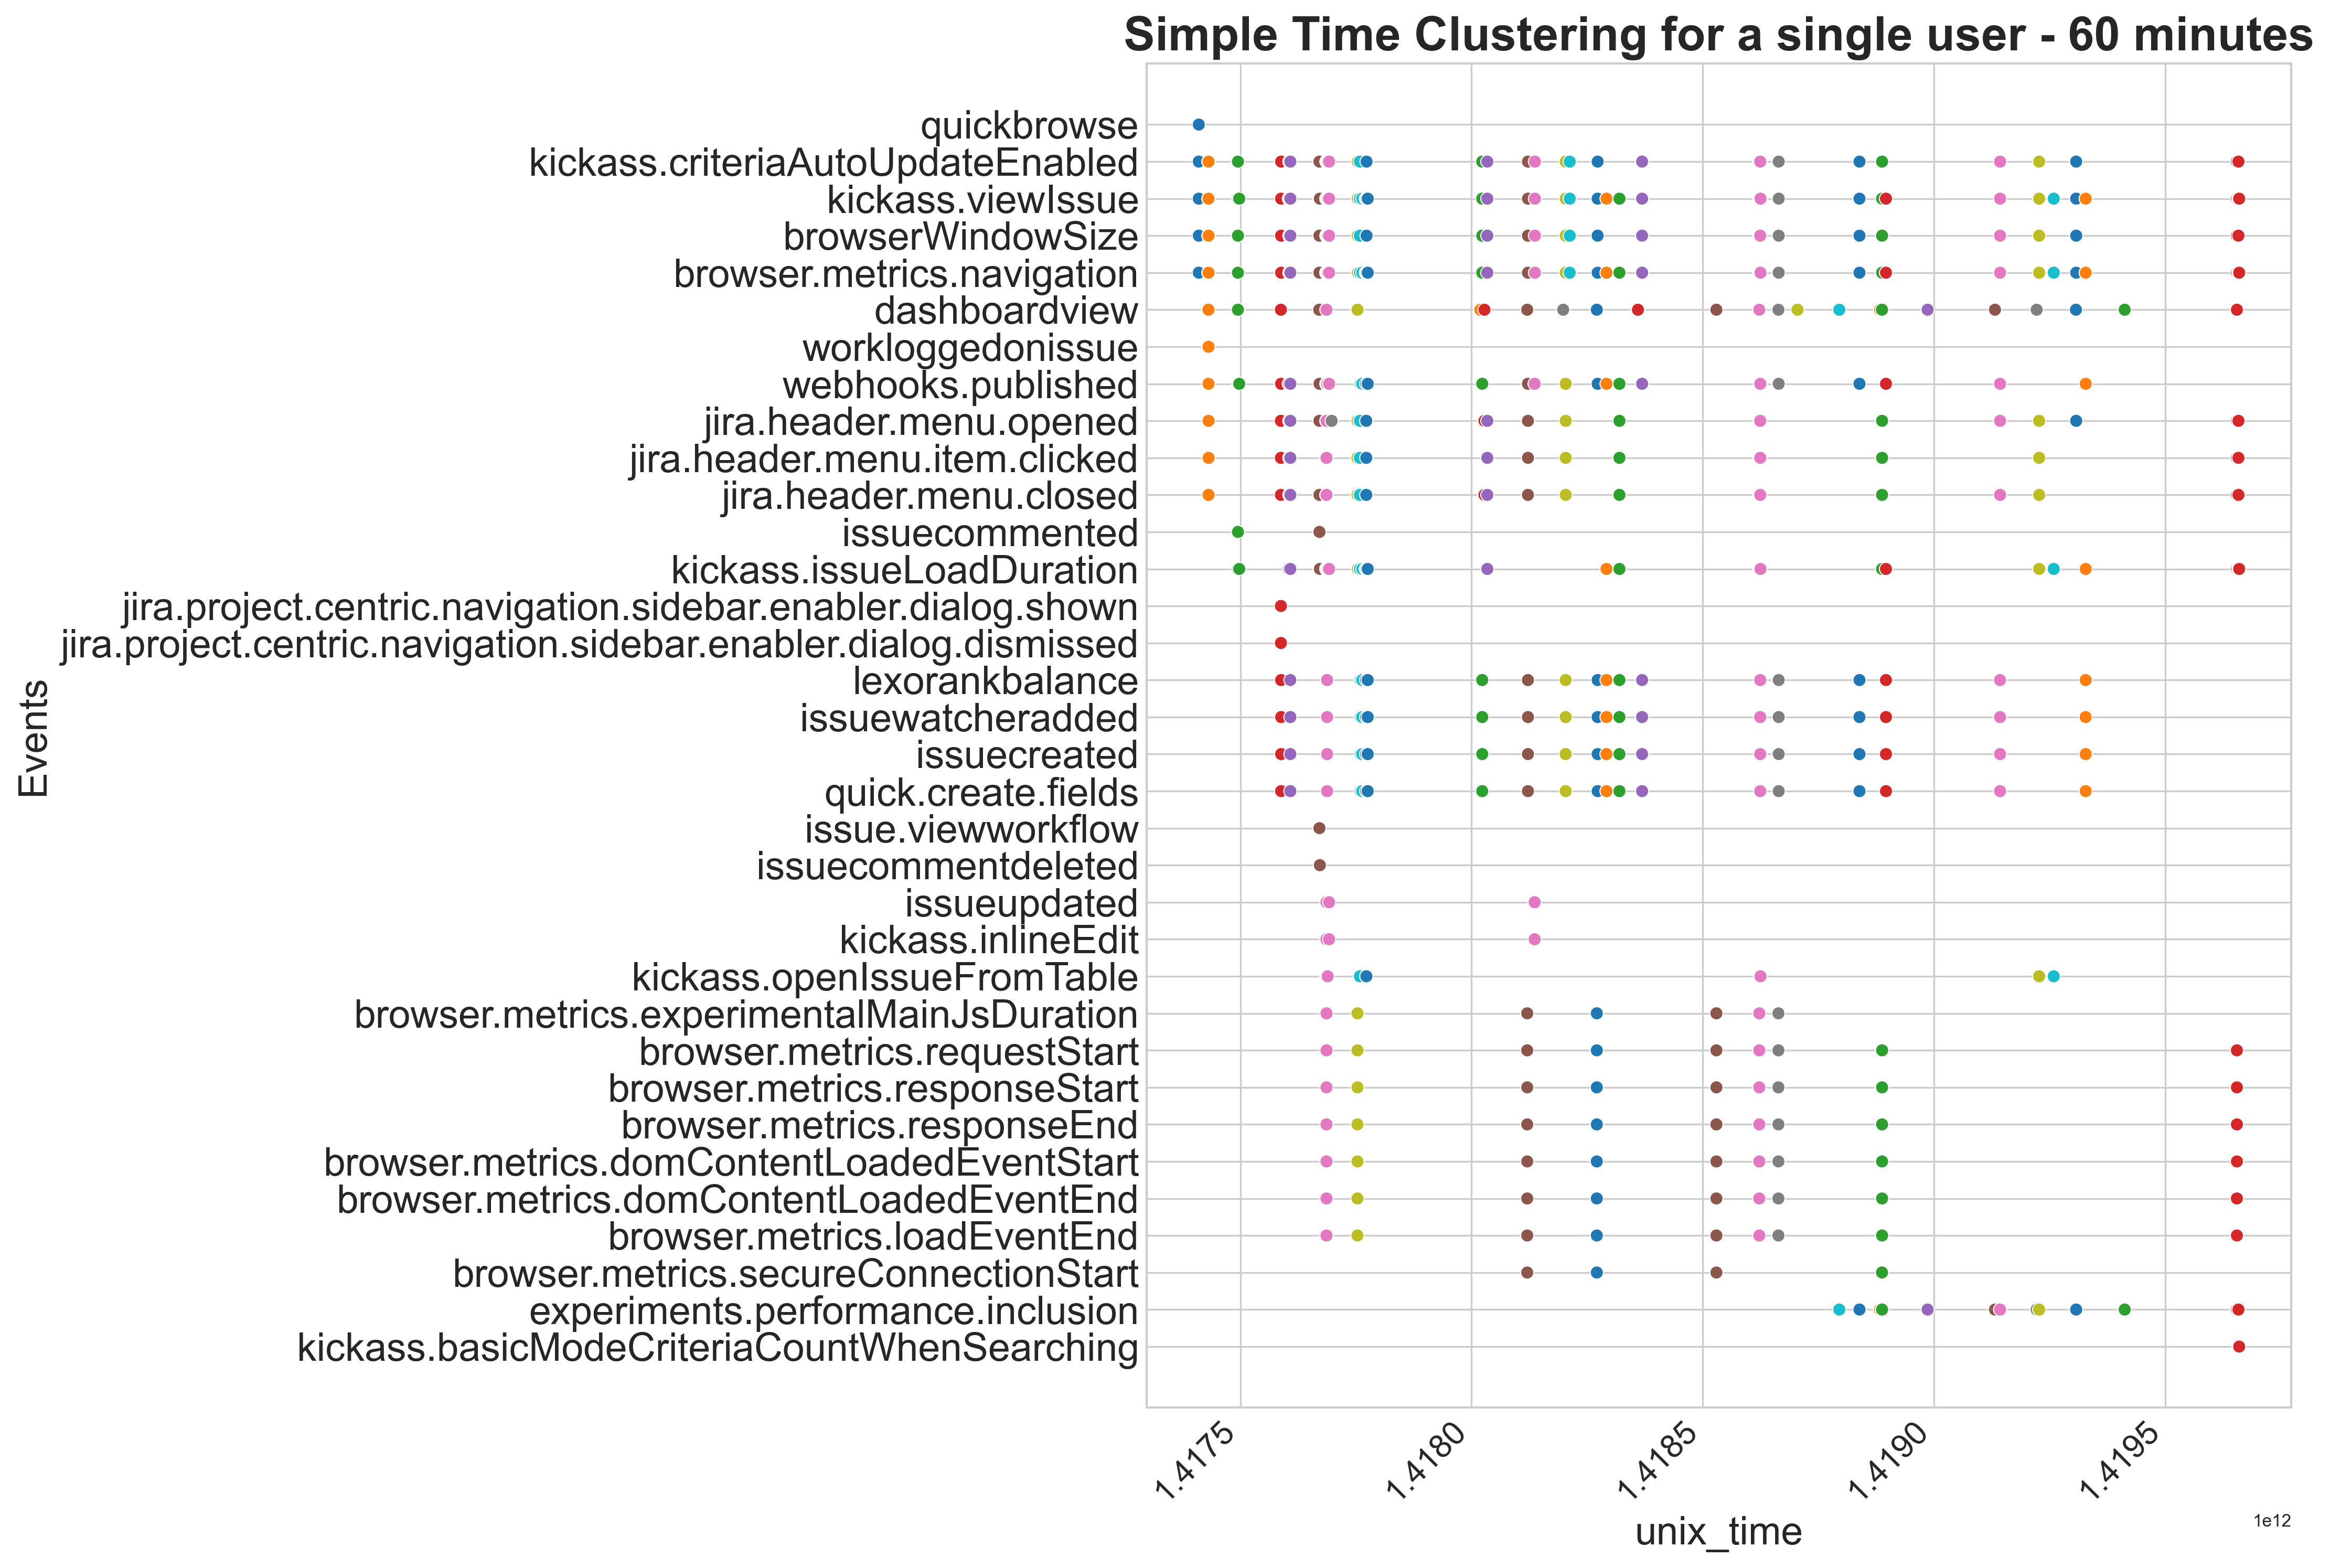

In [24]:
plt.figure(figsize=(15,10))
y = sns.scatterplot(x="unix_time", y="event", hue= 'simple_clusters_60m',data=dfus, legend=None, palette='tab10')
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='small'  
)
plt.tight_layout()
plt.title('Simple Time Clustering for a single user - 60 minutes', weight='bold')
plt.ylabel('Events')
plt.show()

With a 60 minute interval, we can see our clusters have become larger. i.e. we are including more events that occur close to each other. Whereas previously with a 1 minute interval we only found clusters with 4 events, now we have many more

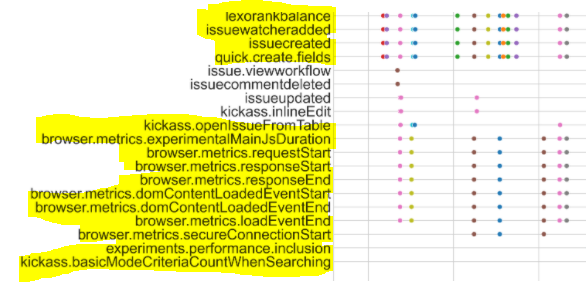



In reality, there is no perfect window to select here. What we need to do is understand the business context.

For example, the marketing time might be interested in these clusters to find out how many 'times' users get on Jira during the day. For this problem statement we might pick a window close to 60 minutes as that's the length of a typical work sprint for the average person.

In another instance, the product or UX team might want to understand a more detailed view of the user and exactly how they're interacting with the product on a minute or second by second basis. For this, we would want to choose a smaller window for our clustering.


**Note:**
It is possible to deploy more complex  clustering algorithms here such as K-means or DBSCAN. However without understanding the business requirements and required outputs, this would not be recommended.

&nbsp;


We can now use our simple clustering approach to create groups of events.

**Hypothesis:** Looking at above cluster charts, it's clear certain events appear more often together. This can be caused by common user actions like opening and editing an issue but there could also be underlying relationships between meta events. e.g. 1 click from user can trigger a sequenced set of events. Let's explore this below.

**Cluster group logic:** we are going to group events that appear within 1 minute of each other. (but again as discussed we will ideally choose this business outcomes in mind.)

In [25]:
# first sort dataframe by user and time
dfa = df.sort_values(by=['username','unix_time'])  

# then calculate absolute time diff between rows in seconds 
dfa['unix_time_diff_seconds'] = abs(dfa['unix_time'].diff()) / 1000 

# then create an id flag for each group (note this isn't our final cluster groups)
dfa['simple_clusters_1m'] = (dfa['unix_time_diff_seconds'] > 60).cumsum()

# Now we're going to group by 1 minute cluster and event types
dfx_prep = sqldf("select simple_clusters_1m, event , count(*) as cnt\
            from dfa  group by 1,2 order by 1")

# create a new column concanating all events that fall within that cluster (sep= ' | ')
dfx = sqldf("select simple_clusters_1m,  GROUP_CONCAT(event,' | ') as event_cc, sum(cnt) as cnt\
            from dfx_prep  group by 1 order by 1")

# roll up counts for all combinations of events that appear together
dfx_sum = sqldf("select event_cc as Event_Groups, sum(cnt) as count from dfx group by 1 order by 2 desc")

# let's look at top event groups
pd.options.display.max_colwidth = 200
dfx_sum.head(10)


Event_Groups  \
0                                                                                                                                                     gh.rapidboard.workMode.collect   
1                                                                             browser.metrics.navigation | browserWindowSize | kickass.criteriaAutoUpdateEnabled | kickass.viewIssue   
2                                                                                                                                                  issueupdated | webhooks.published   
3                                                                            browser.metrics.navigation | kickass.issueLoadDuration | kickass.openIssueFromTable | kickass.viewIssue   
4                          browser.metrics.navigation | browserWindowSize | issueupdated | kickass.criteriaAutoUpdateEnabled | kickass.navigateToIssueNavigator | webhooks.published   
5                                                                                                               issueupdated | kickass.navigateToIssueNavigator | webhooks.published   
6                                                       browser.metrics.navigation | kickass.issueLoadDuration | kickass.openIssueFromTable | kickass.viewIssue | webhooks.published   
7                                         browser.metrics.navigation | browserWindowSize | experiments.performance.inclusion | kickass.criteriaAutoUpdateEnabled | kickass.viewIssue   
8  browser.metrics.navigation | browserWindowSize | experiments.performance.inclusion | jira.devsummary.refresh.github.start | kickass.criteriaAutoUpdateEnabled | kickass.viewIssue   
9                     browser.metrics.navigation | kickass.clickedOnPagniationLink | kickass.issueLoadDuration | kickass.openIssueFromTable | kickass.viewIssue | webhooks.published   

   count  
0  15611  
1   7025  
2   6330  
3   5723  
4   5476  
5   5048  
6   4729  
7   4505  
8   3942  
9   3389

An observation we can make looking at the top event combinations, is that certain category of events tend to accompany each other. e.g. 'browser' events tend to accompany each other. 

In order to intrepret these results better we would want to engage with the product and/or dev team as it's not clear to a lay person what above events relate to.

In [26]:
dfx_sum.count()

Event_Groups    10793
count           10793
dtype: int64

This rather simple algorithm has produced ~10.8k thousand groupings of events.

Again it would be helpful to sit down with the product team and discuss whether this many groupings are helpful.
It might be that we could simplify the events further by only looking at leading descriptor. i.e. 'browser' and categorise all events starting with 'browser' together. 

Whilst we could go into a lot more detail here, without further input from the business teams it's best we move on.




&nbsp;

## 4. Is there anything else you find interesting about the usage pattern you'd like to tell us?



At the start we saw a wide distribution of usage amongst users, let's explore this further..


We can look at segmenting our users from heavy (ntile=5) to lite (ntile=1) usage


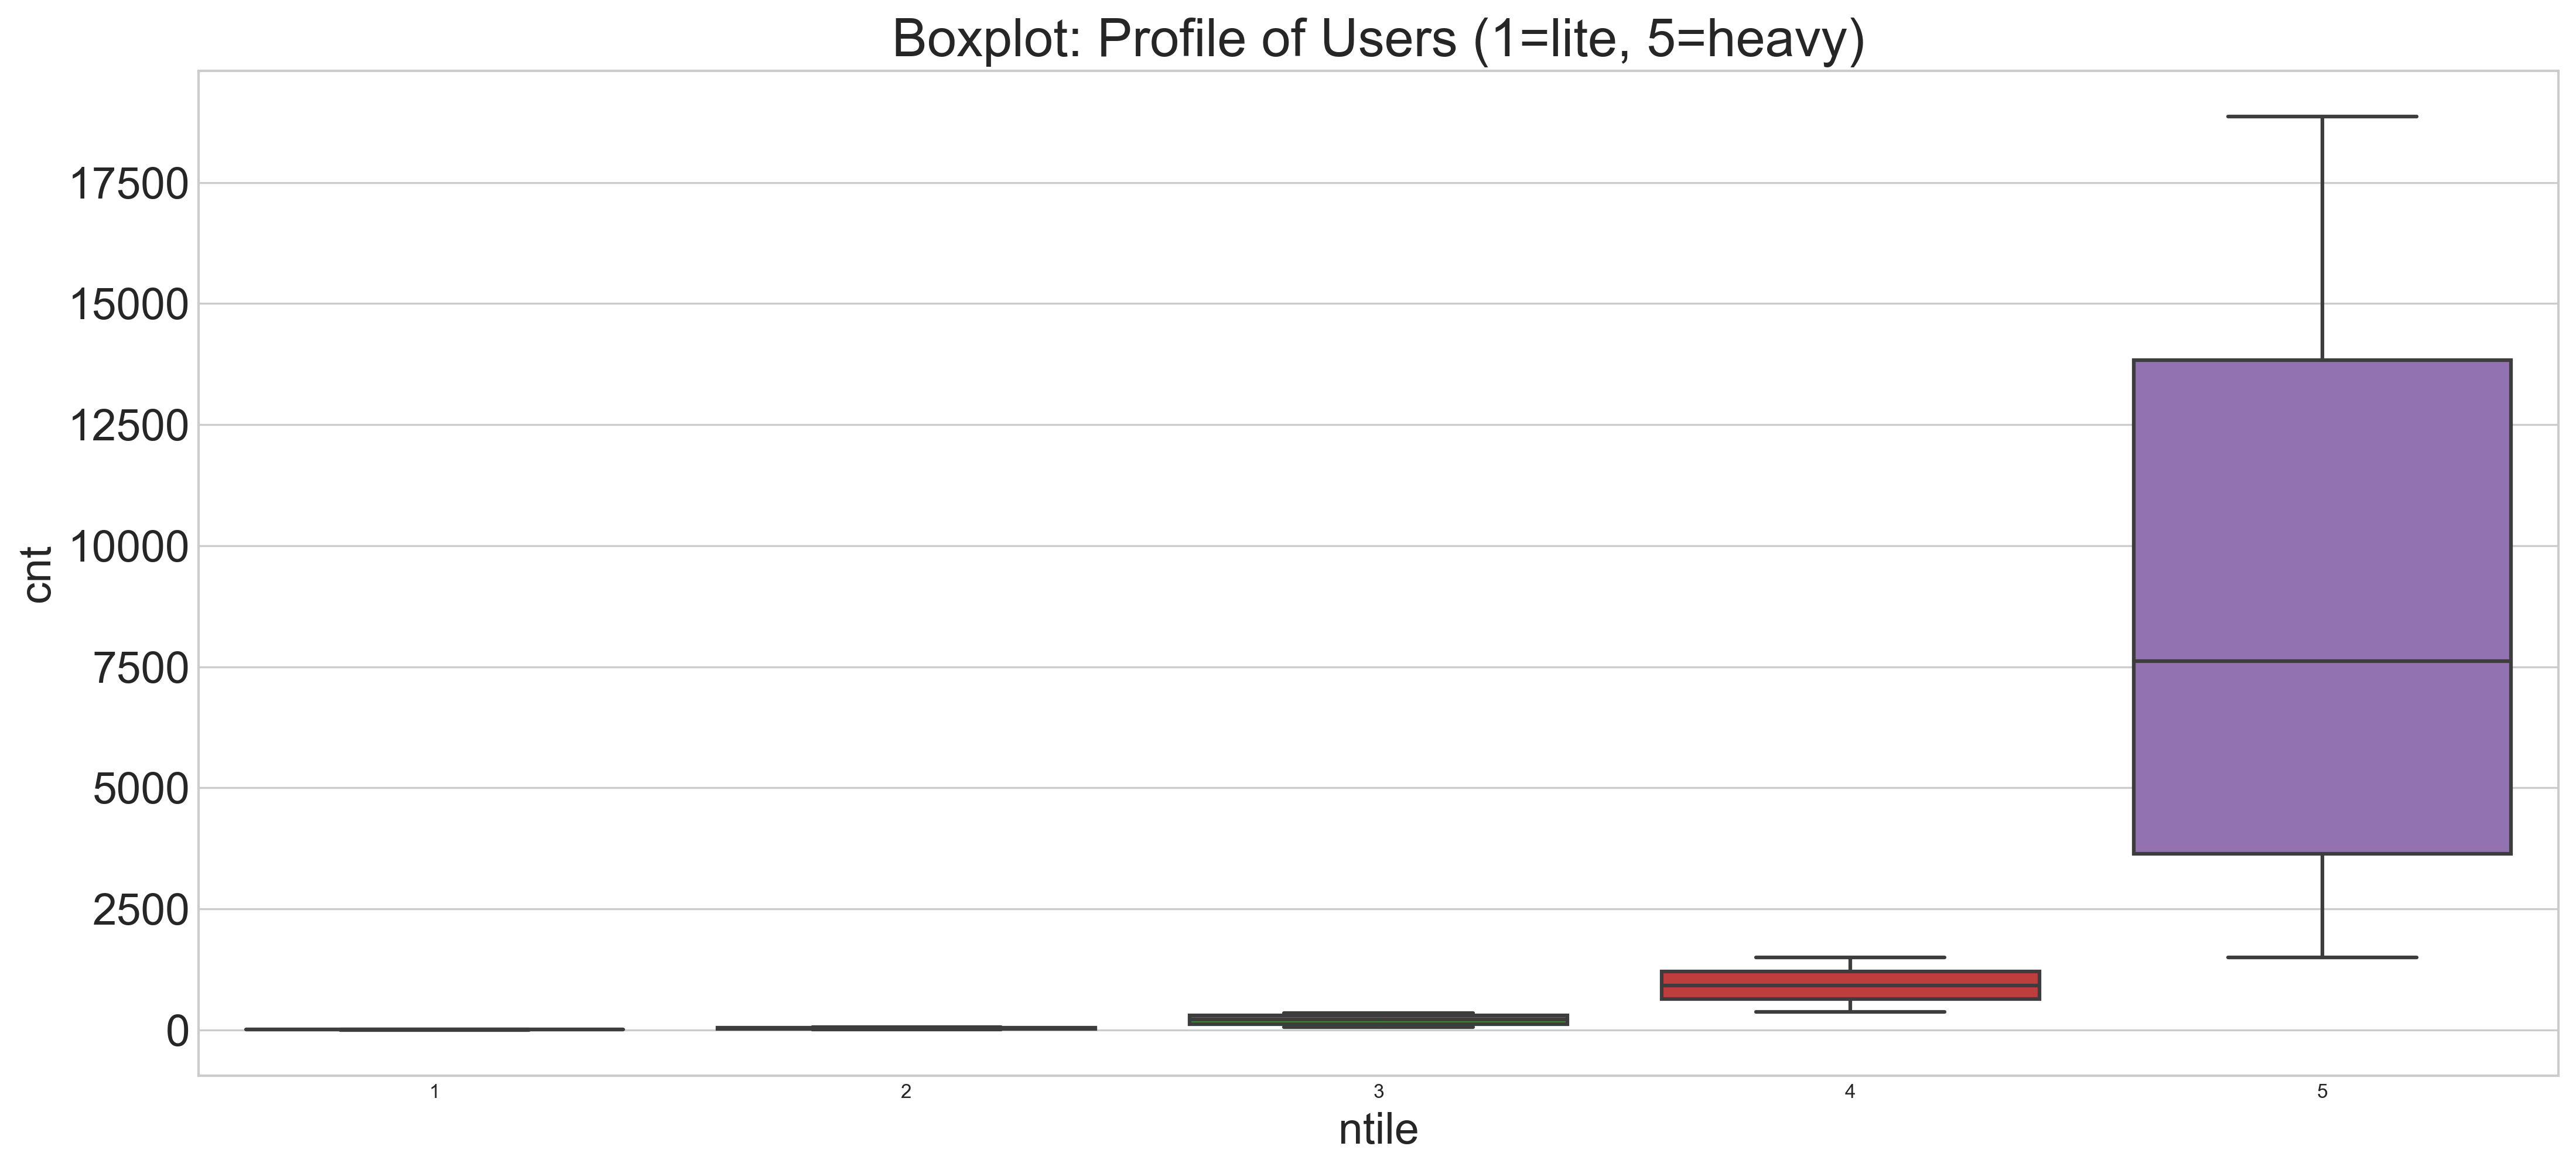

In [27]:
# here we are creating ntiles for most active to least active users broken out into 5 equal buckets
query_1 = """select username, ntile, sum(cnt) as cnt
                from (
                    select username, NTILE (5) OVER (ORDER BY cnt) as ntile, cnt
                    from (select username, count(*) as cnt from dfa  group by 1)
                     )
                group by 1,2"""

user_df = sqldf(query_1)


# then we roll up and calcualte desired metrics
query_2 = """select ntile, count(distinct username) as cnt_users, sum(cnt) as cnt_events 
                 , 1.00*sum(cnt) / sum(sum(cnt)) over() as perc_events
                 from user_df group by 1"""

user_sum = sqldf(query_2)

# merge ntile data with rest of our dataset
dfa_n = pd.merge(dfa, user_df, left_on='username', right_on='username', how='inner')

# boxplot of ntiles
plt.figure(figsize=(15,7))
plt.title('Boxplot: Profile of Users (1=lite, 5=heavy)')
sns.boxplot(data=dfa_n, x='ntile', y='cnt')
plt.tight_layout()
plt.show()

The chart above clearly shows the differences in usage amongst the 5 different group of customers.

Let's see what the distribution of events looks like by these groups..

<Figure size 4500x2100 with 0 Axes>

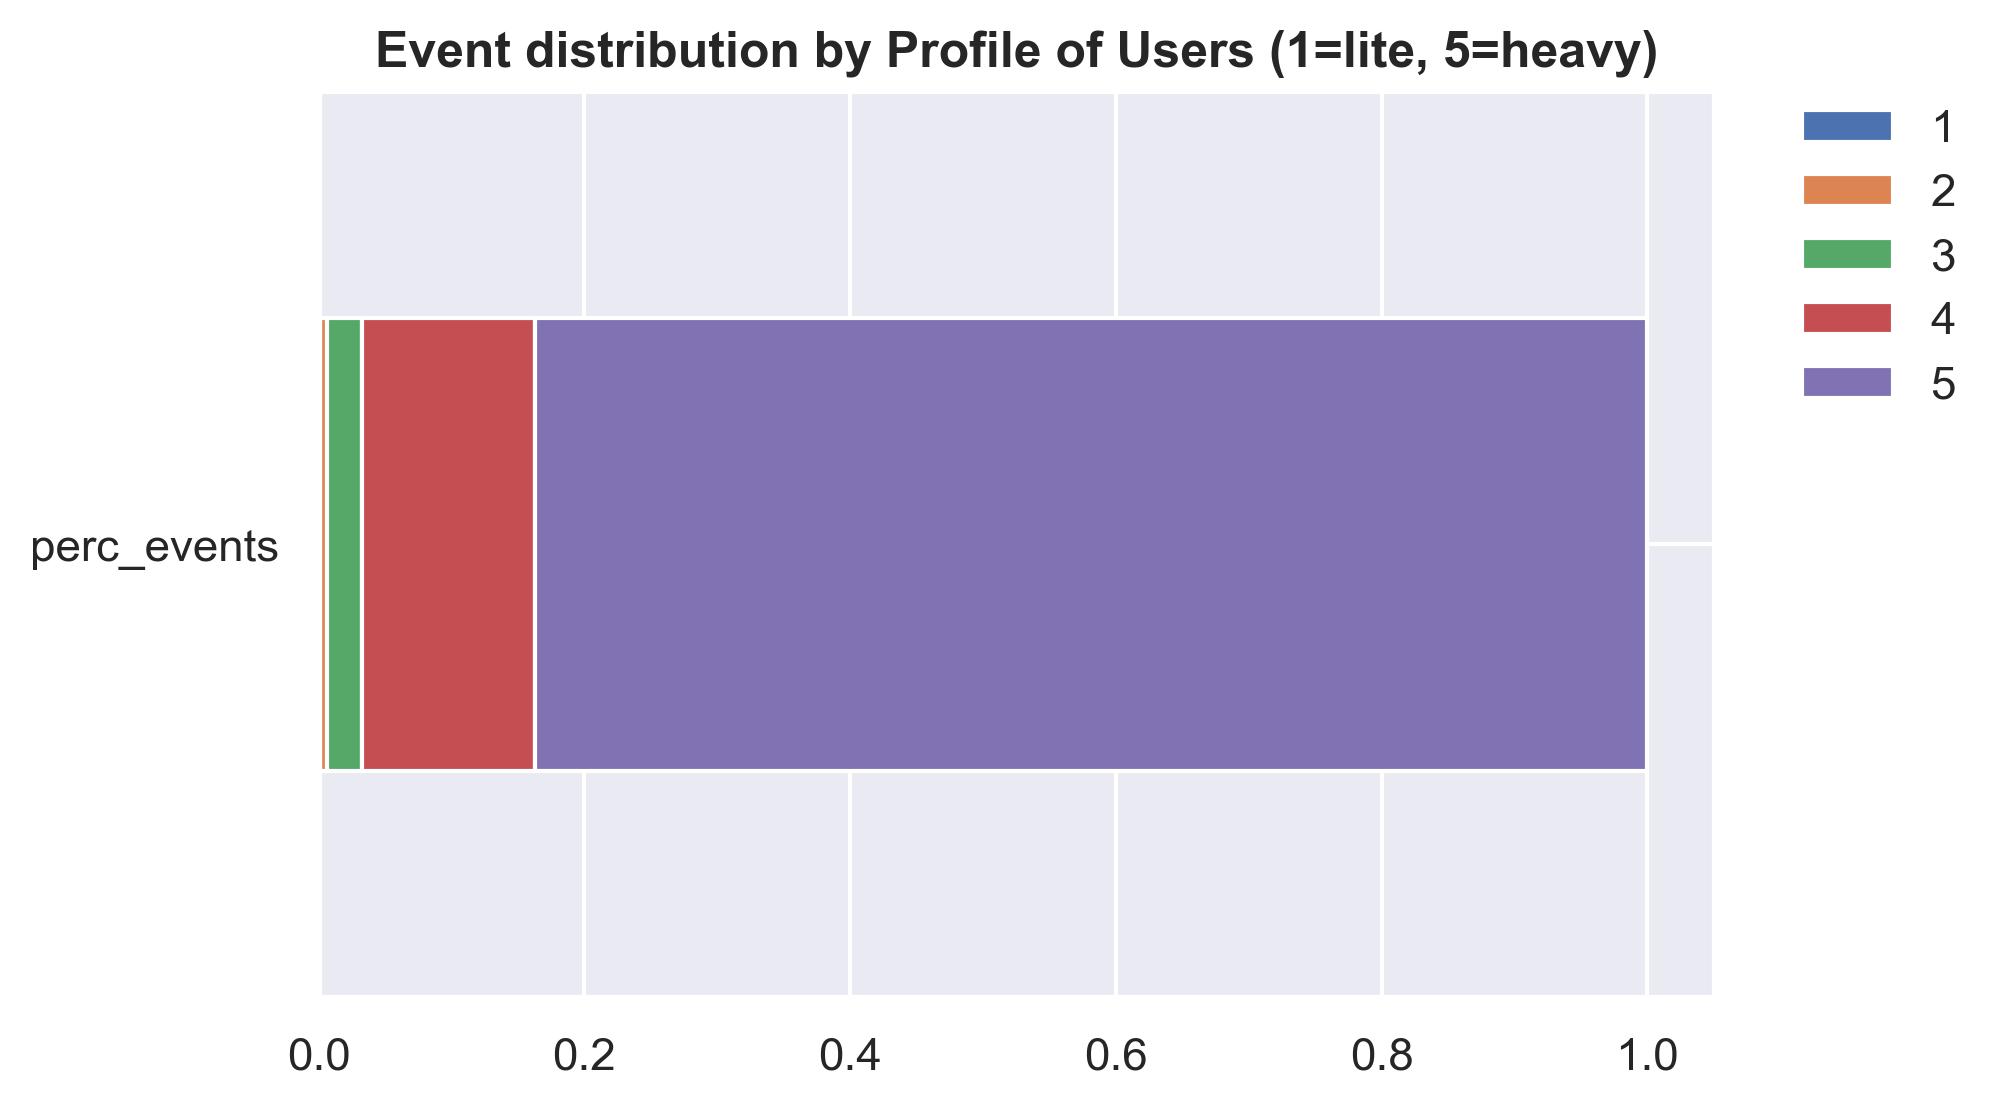

   ntile  cnt_users  cnt_events  perc_events
0      1         98         593     0.001001
1      2         98        3174     0.005357
2      3         97       15741     0.026569
3      4         97       76849     0.129712
4      5         97      496101     0.837361


In [28]:
# then plot the distribution of events by user type
sns.set()
plt.figure(figsize=(15,7))
user_sum[['ntile','perc_events']].set_index('ntile').T.plot(kind='barh', stacked=True)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.) # Put the legend out of the figure
plt.title('Event distribution by Profile of Users (1=lite, 5=heavy)', weight='bold')
plt.show()
print(user_sum)

We can see above, Pareto's principle in action with the top 20% of users accounting for 84% of events on Jira. This is something we may want to communicate to our product/marketing teams to  better understand how we can ensure the needs of these top customers are met.

Let's now look into the differences in usage among different user groups

In [29]:
# look at instances and distribution of users split by ntile
ct = pd.crosstab(dfa_n.instance, dfa_n.ntile, aggfunc='count', values=dfa_n.event, normalize='all').\
style.background_gradient(cmap='hot_r')
ct.format('{:.3f}')

Here we can see that more than a third of all usage comes from the top users (ntile=5) for a single instance `c93da7e17688ef90fc43963b5a6c6259`.

Further, we can see this customer group only accounts for 7.1% of total users.

Again we may want to engage our marketing team to better understand how we could better serve this small group of users that account for large usage on the platform.

In [30]:
ct = pd.crosstab(dfa_n.instance, dfa_n.ntile, aggfunc='nunique', values=dfa_n.username, normalize='all').\
style.background_gradient(cmap='hot_r')
ct.format('{:.3f}')


&nbsp;

**// END**

&nbsp;

**Some considerations/limitations of this analysis:**
- We have looked at a very small sample of just ~16 customers ~500 users over a month. In order to add confidence to our analysis we would want to ensure our findings replicate over a larger dataset
- We have chosen not to explore the attributes of each event in the interests of time, this presents us with potentially a lot of useful data points for each event that could enrich our analysis
- We have chosen not to engage in more complex modeling/clustering until we better understand the business context
- We have decided not to remove any outliers from the analysis without fully understanding the nature of event data. It's possible some top users (ntile=5) have high event counts due to 'meta' events not 'direct' events. This requires more collaboration with product/dev teams who understand the event data better
- We have assumed a general audience for this analysis whereas in reality we would work with specific stakeholders and we would be able to tailor the recommendations and insights to their needs and requirements


&nbsp;

&nbsp;

&nbsp;
